In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
import random
random.seed(0)
import numpy as np
np.random.seed(0)
from sklearn.model_selection import train_test_split,StratifiedKFold
import itertools
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
torch.manual_seed(0)
import torch.nn as nn
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.phrases import Phrases, Phraser
nltk.download('punkt')
from torch.utils.data import TensorDataset, DataLoader

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%%capture
!pip install torchtext

In [2]:
import torchtext
from torchtext import data
from torchtext.data import get_tokenizer #https://stackoverflow.com/questions/42711144/how-can-i-install-torchtext

<h1>Load our data</h1>

In [3]:
df_train_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
df_test_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')
df_valid_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')

<h1>We print our data and check for null values</h1><br>

We can observe from the output of the **info** method that there are no null values

In [5]:
print(df_train_set.head(),'\n')
print(df_train_set.info(), '\n')

print(df_valid_set.head(),'\n')
print(df_valid_set.info(), '\n')

print(df_test_set.head(),'\n')
print(df_test_set.info(), '\n')

   New_ID                                               Text Sentiment   Party
0   35027  #απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...   NEUTRAL  SYRIZA
1    9531  Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...  NEGATIVE      ND
2   14146  Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...  POSITIVE     KKE
3   28716  @five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...   NEUTRAL     KKE
4   32886  @ai_katerina Αυτό που είναι συγκλονιστικό είνα...   NEUTRAL  SYRIZA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36630 entries, 0 to 36629
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     36630 non-null  int64 
 1   Text       36630 non-null  object
 2   Sentiment  36630 non-null  object
 3   Party      36630 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None 

   New_ID                                               Text Sentiment   Party
0     435  @GLinard @teza_tereza @AdonisGeorgi

<h1>Barplots that illustrate the number of tweets and their sentiment for each party</h1>

In [6]:
group_df_by_sentiment_party_train = df_train_set.groupby(['Sentiment', 'Party']).size().reset_index(name='NumOfTweets')
group_df_by_sentiment_party_valid = df_valid_set.groupby(['Sentiment', 'Party']).size().reset_index(name='NumOfTweets')

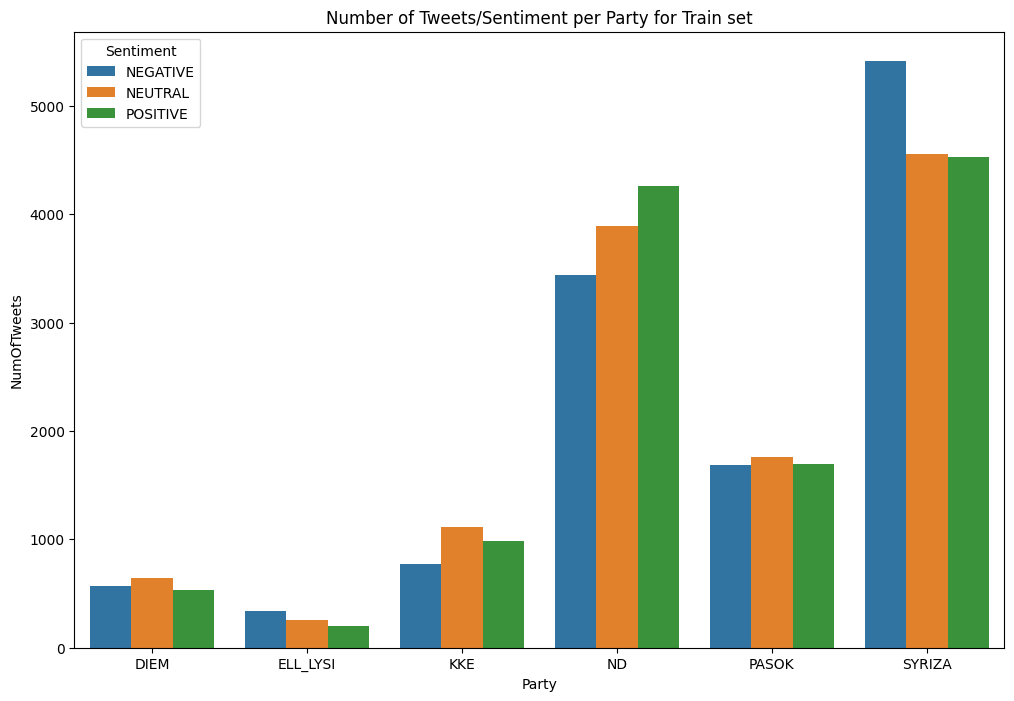

In [7]:
plt.figure(figsize=(12,8))
sns.barplot(x='Party', y='NumOfTweets', hue='Sentiment', data=group_df_by_sentiment_party_train)
plt.title('Number of Tweets/Sentiment per Party for Train set')
plt.show()

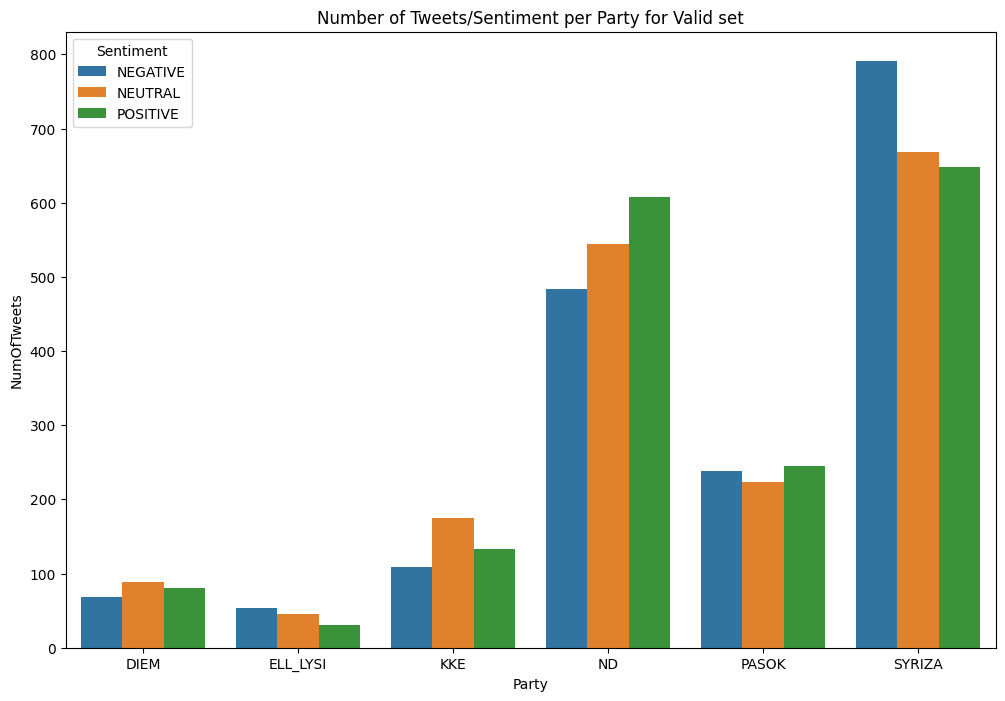

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x='Party', y='NumOfTweets', hue='Sentiment', data=group_df_by_sentiment_party_valid)
plt.title('Number of Tweets/Sentiment per Party for Valid set')
plt.show()

<h1>Plot the number of tweets for each party</h1>

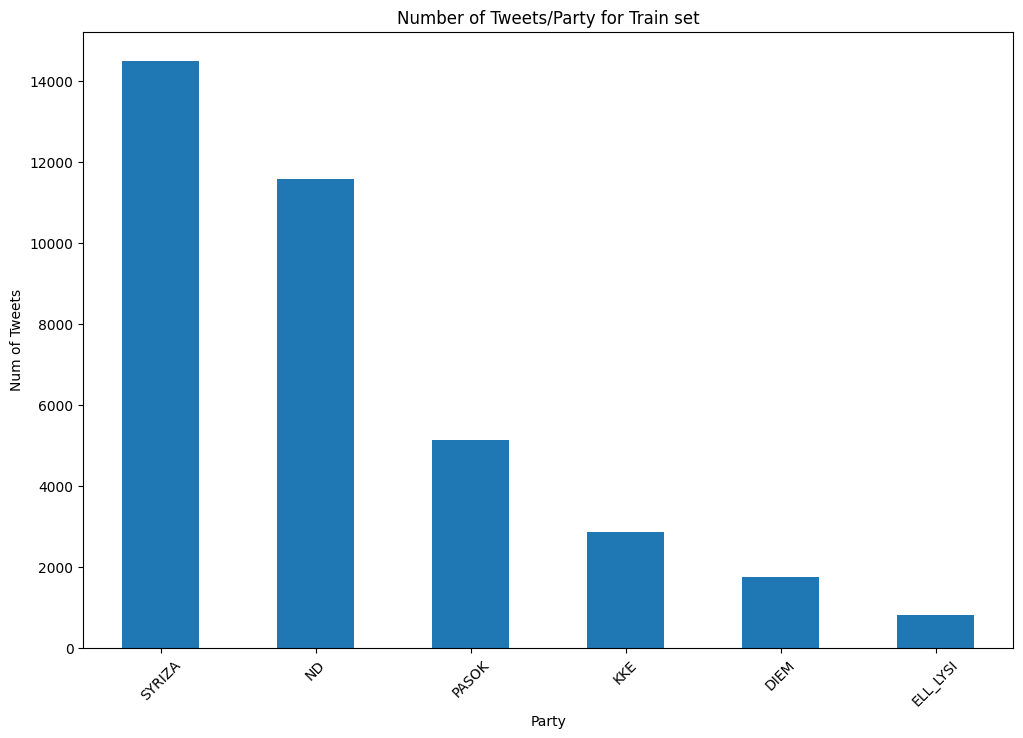

In [9]:
df_train_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Train set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

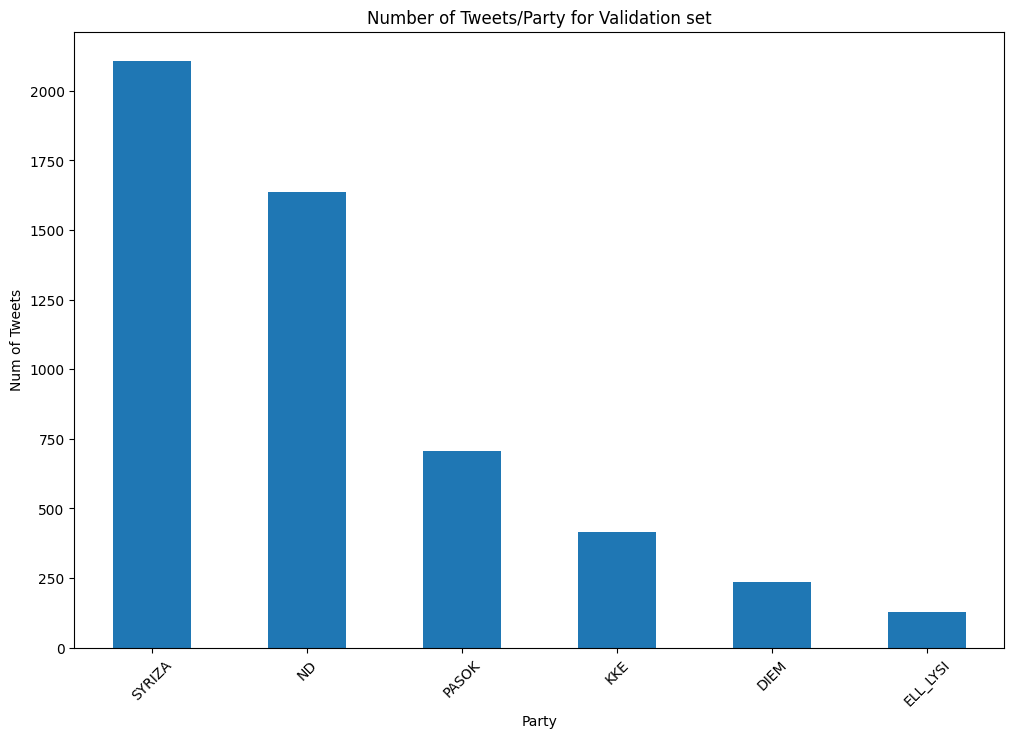

In [10]:
df_valid_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Validation set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

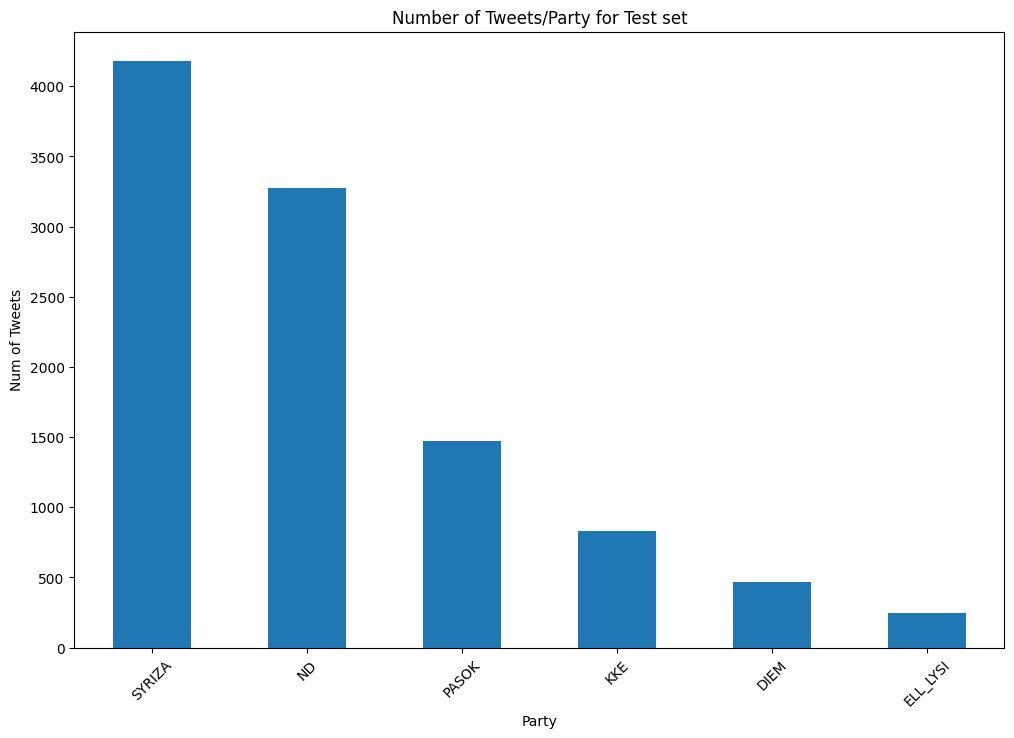

In [11]:
df_test_set['Party'].value_counts().plot(kind='bar', figsize=(12,8))
plt.title('Number of Tweets/Party for Test set')
plt.ylabel('Num of Tweets')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

<h1>Data preprocessing</h1>

<h4>Turn the categorical values to numerical</h4>

In [12]:
df_train_set['Sentiment'].head()

0     NEUTRAL
1    NEGATIVE
2    POSITIVE
3     NEUTRAL
4     NEUTRAL
Name: Sentiment, dtype: object

In [4]:
le = LabelEncoder()

df_train_set['Sentiment'] = le.fit_transform(df_train_set['Sentiment'])
df_valid_set['Sentiment'] = le.fit_transform(df_valid_set['Sentiment'])
print(df_train_set['Sentiment'].head())
print(df_valid_set['Sentiment'].head())

0    1
1    0
2    2
3    1
4    1
Name: Sentiment, dtype: int64
0    2
1    0
2    0
3    2
4    1
Name: Sentiment, dtype: int64


<h4>Function that turn the text of each tweet to lowercase, removes stopwords and special charachters, urls, mentions e.t.c</h4>

In [5]:
# NOTE: To remove the stopwords I downloaded locally the stopwords-el.json file from the repository
# at https://github.com/stopwords-iso/stopwords-el and uploaded it
# to my notebook at gree-stopwords-json-file.

# Load Greek stopwords from the JSON file
with open('/kaggle/input/greek-stopwords-3/stopwords_el_2.json', 'r', encoding='utf-8') as file:
    greek_stopwords = json.load(file)

def preprocess_tweet(tweet):
    tweet = tweet.lower().replace('_', ' ')
    
    # delete mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # delete urls
    tweet = re.sub(r'http\S+', '', tweet)
    
    # delete special characters but keep the alphanumeric ones, including all Greek letters
    #tweet = re.sub(r'[^αβγδεζηθικλμνξοπρστυφχψωςάέίόώύήΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩa-zA-Z0-9\s]', '', tweet)
    
    # I keep only greek charachters (I used to keep and english, I am trying it this way to see if I
    # will achieve higher f1 score)
    tweet = re.sub(r'[^αβγδεζηθικλμνξοπρστυφχψωςάέίόώύήΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ0-9\s]', '', tweet)
    
    # delete Greek stopwords
    tweet_words = tweet.split()
    cleaned_words = [word for word in tweet_words if word not in greek_stopwords]
    tweet = ' '.join(cleaned_words)

    tweet = tweet.strip()
    
    return tweet

In [6]:
df_train_set['Text'] = df_train_set['Text'].apply(preprocess_tweet)
df_test_set['Text'] = df_test_set['Text'].apply(preprocess_tweet)
df_valid_set['Text'] = df_valid_set['Text'].apply(preprocess_tweet)

In [16]:
print(df_train_set['Text'].head(), '\n')
print(df_test_set['Text'].head(), '\n')
print(df_valid_set['Text'].head(), '\n')

0    απολυμανση κοριοι απεντομωση κοριος απολυμανσε...
1    έξι νέες επιστολές μακεδονία καίνε νδ μητσοτάκ...
2     ισχυρό κκε δύναμη λαού βουλή καθημερινούς αγώνες
3             μνημονιακότατο μερα25 εκλογες 2019 8 κκε
4                     συγκλονιστικό ψυχασθένεια τσίπρα
Name: Text, dtype: object 

0    κυριάκος μητσοτάκης ξέρει μουσείο βεργίνας μέσ...
1    συνέντευξη υποψήφιας βουλευτή νέα δημοκρατία β...
2    εκλογές μαθητές φοιτητές ψηφίζουμε ίδιο τρόπο ...
3    γεννηματά κιναλ γίνει δεκανίκι κανενός ενδιαφέ...
4    κυριακή εκλογών οκτώβρης 1993 ξημερώματα δευτέ...
Name: Text, dtype: object 

0    θελεις μιλησεις βοσκοτοπια αιγιαλους παραγραφέ...
1    τσίπρας ζητήσαμε αντιπολίτευση συμμετέχει διαδ...
2    σωστος ελληνας δημοκρατης ελληνας εξωτερικου ε...
3    βλέπεις ενδιαφέρουν μητσοτακηδες γιατί πήγε κό...
4    συνέντευξη μητσοτάκη αίρεση 13η σύνταξη αύξηση...
Name: Text, dtype: object 



**We load the spacy model to perform lemmatization tokenaziation for greek words** <br>
Sometimes it's necessary to restart the kernel in order for the following to work

<h1>ATTENTION:</h1><h2>The following command needs to be executed only one time. If an error occurs from the following spacy.load() command just restart the kernel and run all the commands except this one.</h2>

In [17]:
%%capture
# This needs to be executed only one time. If an error occurs from the following spacy.load() command
# just restart the kernel and run all the commands except this one.
!pip install -U spacy  

In [7]:
nlp = spacy.load('/kaggle/input/el-core-news-lg-2/el_core_news_lg/el_core_news_lg-3.7.0')

<h1>LEMMATIZATION - TOKENIZATION</h1>

In [8]:
# For the lemmatization tokenazation step, I downloaded locally the el_core_news_lg model,
# then I zipped it and I uploaded it as a public dataset.
def lemmatize_tokenize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])


df_train_set['Text'] = df_train_set['Text'].apply(lemmatize_tokenize_text)
df_test_set['Text'] = df_test_set['Text'].apply(lemmatize_tokenize_text)
df_valid_set['Text'] = df_valid_set['Text'].apply(lemmatize_tokenize_text)

In [20]:
print(df_train_set['Text'].head(), '\n')
print(df_test_set['Text'].head(), '\n')
print(df_valid_set['Text'].head(), '\n')

0    απολυμανση κοριοι απεντομωση κοριος απολυμανσε...
1    έξι νέος επιστολή μακεδονία καίνε νδ μητσοτάκη...
2     ισχυρός κκε δύναμη λαός βουλή καθημερινός αγώνας
3             μνημονιακότατο μερα25 εκλογες 2019 8 κκε
4                   συγκλονιστικός ψυχασθένεια τσίπρας
Name: Text, dtype: object 

0    κυριάκος μητσοτάκης ξέρω μουσείο βεργίνας μέσω...
1    συνέντευξη υποψήφιος βουλευτής νέος δημοκρατία...
2    εκλογή μαθητής φοιτητής ψηφίζω ίδιος τρόπος αγ...
3    γεννηματά κιναλ γίνομαι δεκανίκι κανενός ενδια...
4    κυριακός εκλογή οκτώβρης 1993 ξημερώματα δευτέ...
Name: Text, dtype: object 

0    θελεις μιλησεις βοσκοτοπια αιγιαλος παραγραφή ...
1    τσίπρας ζητήζω αντιπολίτευση συμμετέχω διαδικα...
2    σωστος ελληνας δημοκρατης ελληνας εξωτερικου ε...
3    βλέπεις ενδιαφέρω μητσοτακηδας γιατί πήγε κότε...
4    συνέντευξη μητσοτάκης αίρεση 13ος σύνταξη αύξη...
Name: Text, dtype: object 



<h1> Number of Unique words - Wordcloud</h1>

In [21]:
def unique_words_num(tweets):
    # Function that counts the number of the unique words from the Text column of each dataframe
    words = set() 
    for tweet in tweets:
        words.update(tweet.split())
    return len(words)

In [22]:
print("Num of unique words in df_train_set:", unique_words_num(df_train_set['Text']))
print("Num of unique words in df_test_set:", unique_words_num(df_test_set['Text']))
print("Num of unique words in df_valid_set:", unique_words_num(df_valid_set['Text']))

Num of unique words in df_train_set: 58402
Num of unique words in df_test_set: 26281
Num of unique words in df_valid_set: 16629


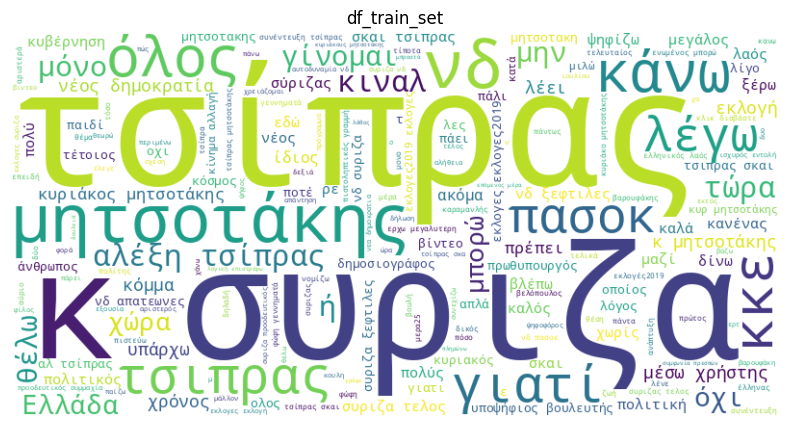

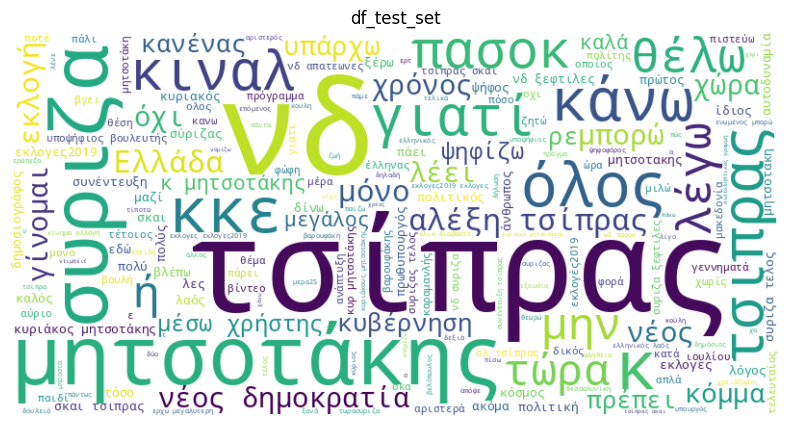

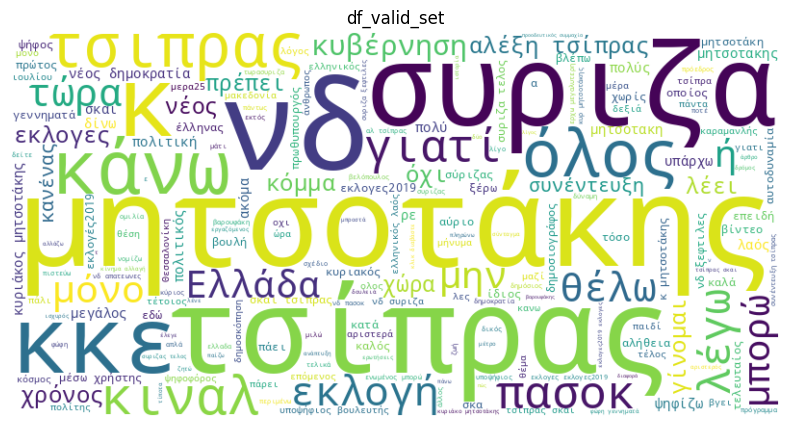

In [23]:
def plot_wordcloud(tweets, title):
    tweets_joined = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(tweets_joined)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word cloud for each dataframe
plot_wordcloud(df_train_set['Text'], 'df_train_set')
plot_wordcloud(df_test_set['Text'], 'df_test_set')
plot_wordcloud(df_valid_set['Text'], 'df_valid_set')

<h1>Word2Vec</h1>

<p>Μετατροπή κειμένου σε vector representation με Word2Vec</p>
<p>Train Word2Vec model</p>

In [9]:
all_text = pd.concat([df_train_set['Text'], df_test_set['Text'], df_valid_set['Text']])
tokenized_text = [text.split() for text in all_text]

# training
w2v_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

In [10]:
# https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/
def vectorize(sentence, w2v_model):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [11]:
df_train_set_vectorized = df_train_set
df_valid_set_vectorized = df_valid_set
df_test_set_vectorized = df_test_set

In [12]:
df_train_set_vectorized['Text'] = df_train_set_vectorized['Text'].apply(lambda x: vectorize(x, w2v_model))
df_test_set_vectorized['Text'] = df_test_set_vectorized['Text'].apply(lambda x: vectorize(x, w2v_model))
df_valid_set_vectorized['Text'] = df_valid_set_vectorized['Text'].apply(lambda x: vectorize(x, w2v_model))

In [28]:
df_train_set_vectorized['Text'].head()

0    [-0.3705325, 0.2766968, 0.36165315, 0.14418791...
1    [0.32445583, 1.1292791, 0.14050303, -0.0479903...
2    [-0.13751322, 1.2702442, 0.2295541, -1.4705985...
3    [-0.53654575, 0.6961232, 0.6062937, -1.088708,...
4    [-0.40646818, 0.91629076, 0.62459475, 0.112659...
Name: Text, dtype: object

In [13]:
# CONVERT DATA TO TENSORS
X_train = torch.tensor(df_train_set_vectorized['Text'].tolist(), dtype=torch.float)
y_train = torch.tensor(df_train_set_vectorized['Sentiment'].values, dtype=torch.float)
X_valid = torch.tensor(df_valid_set_vectorized['Text'].tolist(), dtype=torch.float)
y_valid = torch.tensor(df_valid_set_vectorized['Sentiment'].values, dtype=torch.float)

# CREATE DATALOADERS
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_47/489381530.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor(df_train_set_vectorized['Text'].tolist(), dtype=torch.float)


<h1> Model 1</h1>

In [16]:
def train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader):
    train_acc, valid_acc = [], []
    train_f1, valid_f1 = [], []
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []

    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.long())
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate metrics for training
        train_acc.append(accuracy_score(train_labels, train_preds))
        train_f1.append(f1_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_precision.append(precision_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_recall.append(recall_score(train_labels, train_preds, average='weighted', zero_division=0))

        # Validation phase
        model.eval()
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                valid_preds.extend(predicted.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        # Calculate metrics for validation
        valid_acc.append(accuracy_score(valid_labels, valid_preds))
        valid_f1.append(f1_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_precision.append(precision_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_recall.append(recall_score(valid_labels, valid_preds, average='weighted', zero_division=0))

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Acc: {train_acc[-1]:.2f}, Valid Acc: {valid_acc[-1]:.2f}, '
              f'Train F1: {train_f1[-1]:.2f}, Valid F1: {valid_f1[-1]:.2f}, '
              f'Train Precision: {train_precision[-1]:.2f}, Valid Precision: {valid_precision[-1]:.2f}, '
              f'Train Recall: {train_recall[-1]:.2f}, Valid Recall: {valid_recall[-1]:.2f}')


    print(f'MEAN TRAIN ACCURACY: {np.mean(train_acc):.2f}\n'
          f'MEAN VALIDATION ACCURACY: {np.mean(valid_acc):.2f}\n'
          f'MEAN TRAIN F1 SCORE: {np.mean(train_f1):.2f}\n'
          f'MEAN VALIDATION F1 SCORE: {np.mean(valid_f1):.2f}\n'
          f'MEAN TRAIN PRECISION: {np.mean(train_precision):.2f}\n'
          f'MEAN VALIDATION PRECISION: {np.mean(valid_precision):.2f}\n'
          f'MEAN TRAIN RECALL: {np.mean(train_recall):.2f}\n'
          f'MEAN VALIDATION RECALL: {np.mean(valid_recall):.2f}\n')
    return train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision


In [17]:
def plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision):
    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed

    # Plotting training and validation F1 Score
    plt.subplot(1, 3, 1)  # First subplot in a 1x3 grid
    plt.plot(train_f1, label='Train F1 Score')
    plt.plot(valid_f1, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plotting training and validation Precision Score
    plt.subplot(1, 3, 2)  # Second subplot in a 1x3 grid
    plt.plot(train_precision, label='Train Precision Score')
    plt.plot(valid_precision, label='Validation Precision Score')
    plt.title('Training and Validation Precision Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Precision Score')
    plt.legend()

    # Plotting training and validation Recall Score
    plt.subplot(1, 3, 3)  # Third subplot in a 1x3 grid
    plt.plot(train_recall, label='Train Recall Score')
    plt.plot(valid_recall, label='Validation Recall Score')
    plt.title('Training and Validation Recall Score')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')
    plt.legend()

    # Show the plot
    plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
    plt.show()

In [37]:
# https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.linear3(x)
        return x
    


Epoch 1/10, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.37, Valid Precision: 0.41, Train Recall: 0.37, Valid Recall: 0.38
Epoch 2/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/10, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/10, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/10, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/10, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 7/10, Train Acc:

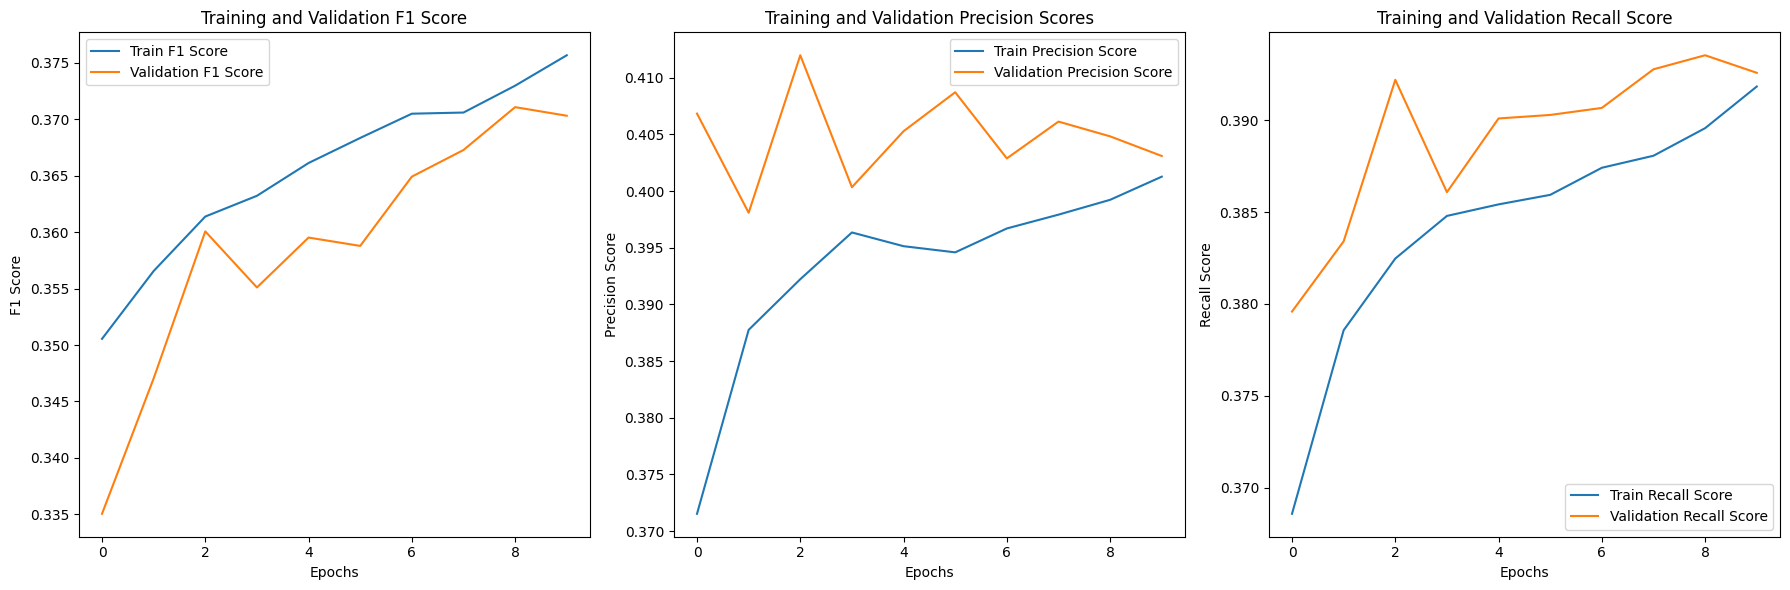

In [40]:
# TRAIN THE MODEL
model = Net(D_in=100, H1=128, H2=64, D_out=3)
loss_func = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Observartions</h2>

<p>
<b>Fluctuating Accuracy</b>: We observe that the metrics we print fluctuate over the epochs. This could be a sign of the model not consistently learning from epoch to epoch. Ideally, we would expect a general trend of increasing accuracy as the epochs progress.

<b>Validation Accuracy VS Training Accuracy</b>: The validation accuracy is generally the same as the training accuracy, which is typical sign of our model overfitting, sometimes validation accuracy surpasses training accuracy, which is unusual and might indicate <b>variability in the data</b> (which is logical since we have to do with tweets) or model's learning process.

<b>F1 Scores</b>: The F1 scores are relatively stable and hover around the same values throughout the epochs. This might suggest that the model is consistently predicting a certain class or set of classes well, but not necessarily improving across all classes.

<b>Possible Overfitting</b>: The training-validation accuracy from what we can observe from the returned values of each epoch, are almost the same every time which indicates overfitting.

<b>Model Stability</b>: The variability in accuracy and F1 score from epoch to epoch suggests that the model is not very stable. This could be due to several factors, including the choice of model architecture, learning rate, or the nature of the data itself.
</p>

<h1>Experiments with the layers</h1>
<p> I will add more layers to observe if my model becomes more stable</p>

<h2>4 hidden layers</h2>

In [42]:
# We construct a nn with 4 hidden layers
class Net_2(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_2, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


In [47]:
model = Net_2(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

Epoch 1/10, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.33, Train Precision: 0.37, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/10, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/10, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 5/10, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/10, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 7/10, Train Acc:

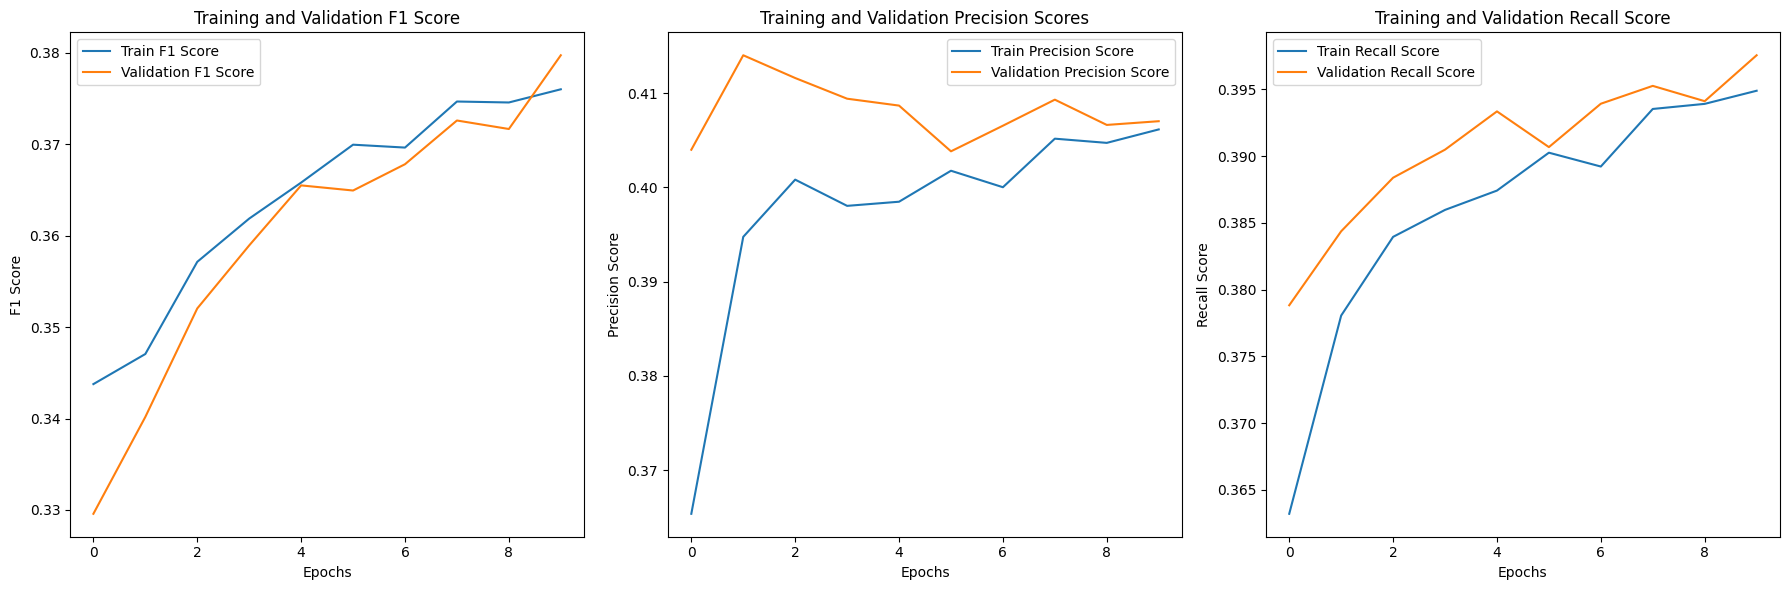

In [48]:
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Observations for model with 4 hidden layers</h2>
<p>

<b>Accuracy and F1 Score</b>: The accuracy and F1 score fluctuate across epochs, but there is no clear upward trend indicating consistent improvement.

<b>Final Epoch Performance</b>: By the final epoch, the model achieves a training accuracy of 40.91% and a validation accuracy of 41.67%, with corresponding F1 scores of 0.39 and 0.38.

<b>General Performance</b>: The model shows some balance between training and validation performance, suggesting that it's not significantly overfitting. However, the overall performance is moderate, indicating that the model might not be complex enough to capture the underlying patterns in the data effectively.
</p>

<p>We observe that the fluctuation remains. We will add 2 more layers but we do not expect to achieve better results since it's evident that the layers do not hold great role for that specific task</p>

<h2>6 hidden layers</h2>

In [49]:
# We construct a nn with 6 hidden layers
class Net_3(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, H5, H6, D_out):
        super(Net_3, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, H5)
        self.act_5 = nn.ReLU()
        self.linear6 = nn.Linear(H5, H6)
        self.act_6 = nn.ReLU()
        self.linear7 = nn.Linear(H6, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.act_5(self.linear5(x))
        x = self.act_6(self.linear6(x))
        x = self.linear7(x)
        return x

In [50]:
model = Net_3(D_in=100, H1=264, H2=264, H3=264, H4=128, H5=64, H6=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

Epoch 1/10, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.33, Valid F1: 0.28, Train Precision: 0.35, Valid Precision: 0.47, Train Recall: 0.35, Valid Recall: 0.37
Epoch 2/10, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.32, Valid F1: 0.33, Train Precision: 0.39, Valid Precision: 0.39, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.41, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.41, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 5/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.41, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 6/10, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.41, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 7/10, Train Acc:

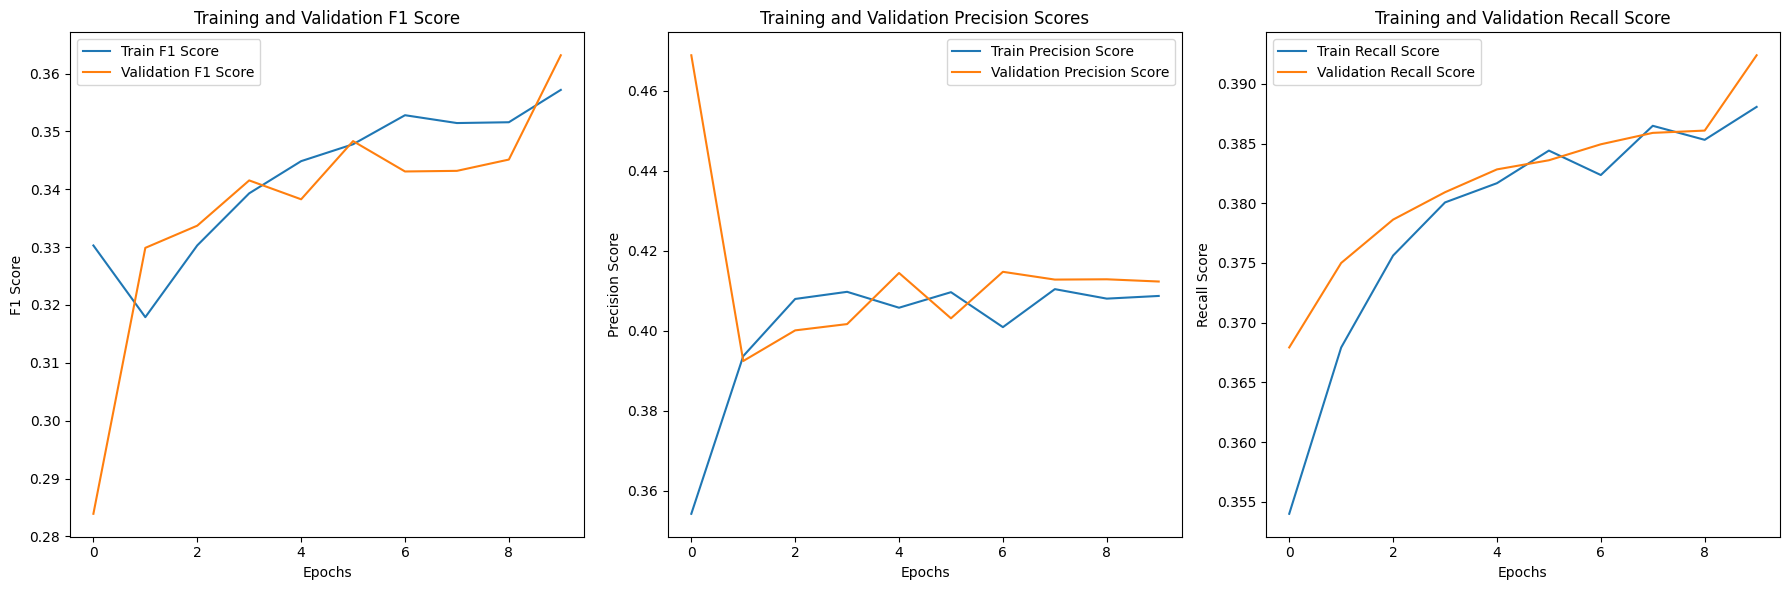

In [51]:
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Observations for the model with 6 hidden layers</h2>

<p>
<b>Accuracy and F1 Score</b>: This model also shows fluctuations in performance across epochs, similar to the 4-layer model. However, the F1 score slightly improves over the epochs.
    
<b>Final Epoch Performance</b>: The model ends with a training accuracy of 36.36% and a validation accuracy of 45.83%, with F1 scores of 0.36 and 0.34.
    
<b>General Performance</b>: The increase in the number of hidden layers and neurons doesn't translate into a significant improvement in performance. In some cases, the training accuracy is lower than in the 4-layer model, which could suggest that the added complexity might be causing the model to struggle in effectively learning from the training data.
</p>

<h2>8 hidden layers</h2>

In [52]:
# We construct a nn with 8 hidden layers
class Net_4(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, H5, H6, H7, H8, D_out):
        super(Net_4, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, H5)
        self.act_5 = nn.ReLU()
        self.linear6 = nn.Linear(H5, H6)
        self.act_6 = nn.ReLU()
        self.linear7 = nn.Linear(H6, H7)
        self.act_7 = nn.ReLU()
        self.linear8 = nn.Linear(H7, H8)
        self.act_8 = nn.ReLU()
        self.linear9 = nn.Linear(H8, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.act_5(self.linear5(x))
        x = self.act_6(self.linear6(x))
        x = self.act_7(self.linear7(x))
        x = self.act_8(self.linear8(x))
        x = self.linear9(x)
        return x

In [53]:
model = Net_4(D_in=100, H1=256, H2=128, H3=128, H4=64, H5=64, H6=32, H7=32, H8=16, D_out=3)
loss_func = nn.CrossEntropyLoss()
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

Epoch 1/10, Train Acc: 0.36, Valid Acc: 0.36, Train F1: 0.33, Valid F1: 0.29, Train Precision: 0.36, Valid Precision: 0.24, Train Recall: 0.36, Valid Recall: 0.36
Epoch 2/10, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.37, Train Recall: 0.36, Valid Recall: 0.37
Epoch 3/10, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.33, Valid F1: 0.32, Train Precision: 0.37, Valid Precision: 0.38, Train Recall: 0.36, Valid Recall: 0.37
Epoch 4/10, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.32, Valid F1: 0.32, Train Precision: 0.38, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.37
Epoch 5/10, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.33, Valid F1: 0.32, Train Precision: 0.39, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.37
Epoch 6/10, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.32, Valid F1: 0.32, Train Precision: 0.39, Valid Precision: 0.37, Train Recall: 0.37, Valid Recall: 0.37
Epoch 7/10, Train Acc:

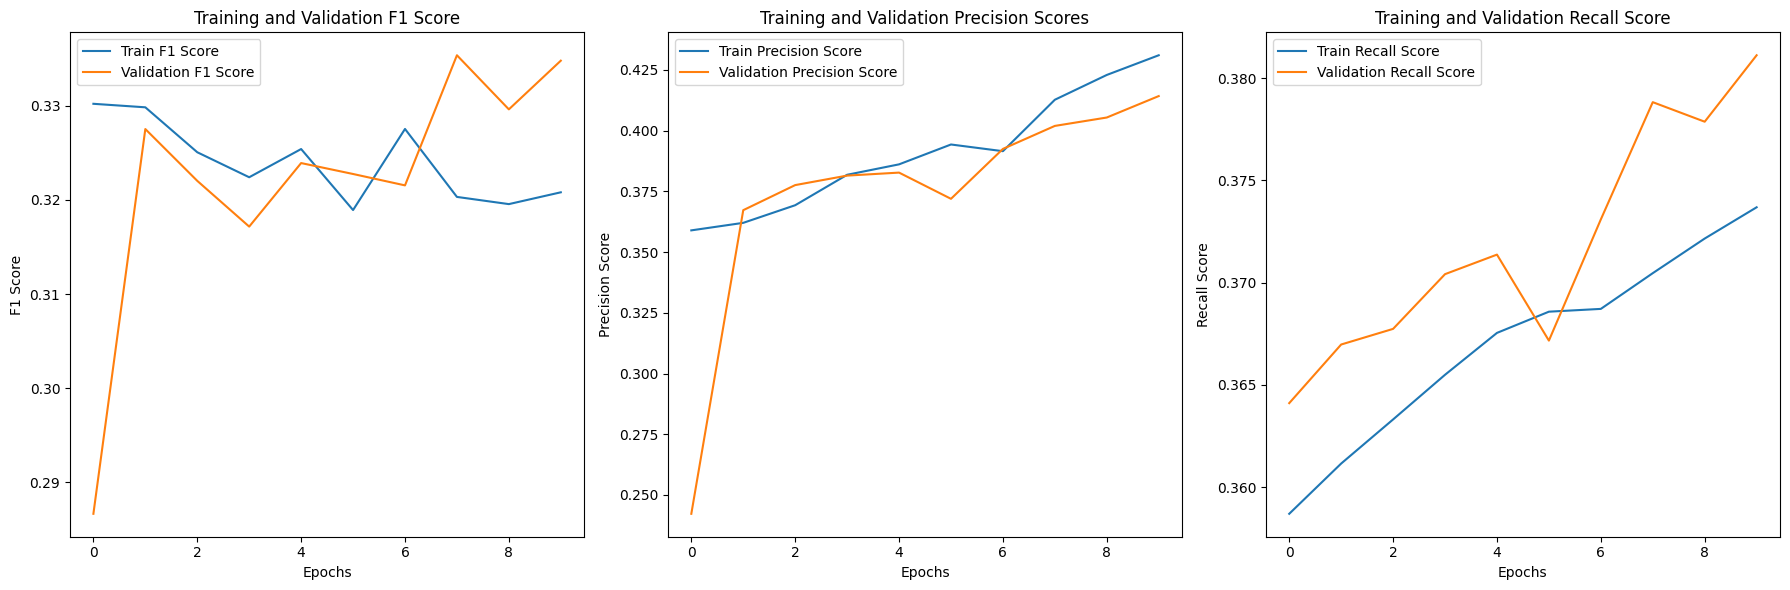

In [54]:
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train(model, loss_func, optimizer, num_epochs, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Observations for the model with 8 hidden layers</h2>
<p>
<b>Fluctuating Accuracy and F1 score</b>: Both accuracy and F1 scores for training and validation fluctuate across the epochs. This fluctuation suggests that the model may not be consistently learning or improving over time.

<b>Low Validation Accuracy and F1 score</b>: validation accuracy and F1 scores are relatively low and do not show significant improvement over the epochs. The best validation accuracy is 45.83%, and the corresponding F1 score is 0.31. These metrics suggest that the model may not be performing well on unseen data.

<b>Possible Overfitting or Underfitting</b>: The discrepancies between training and validation accuracy and F1 scores can indicate either overfitting or underfitting. Overfitting would mean the model is too complex and is learning the noise in the training data, while underfitting would mean the model is too simple to capture the underlying patterns of the data.
</p>

<h1>Experiments with learning rate</h1>

<p>4 Hidden Layers: Has the highest mean validation accuracy and f1 score.
This indicates a better balance between learning from the training data and generalizing to unseen data.</p>

<p>6 and 8 Hidden Layers:Show a decrease in both training and validation performance compared to the 4-layer model. This could be a sign of overfitting, where the increased complexity of the model makes it difficult to generalize well to new, unseen data. Alternatively, it might also indicate that the model is too complex for the amount of training data available, or that it's not learning effectively due to issues like vanishing gradients.</p>

<p><b>For the above reasons we will continue with a 4-layered network</b></p>

<p>We will proceed wiht experiments with the <b>learning rate</b></p>

<p>The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

The learning rate may be the most important hyperparameter when configuring a neural network. Therefore it is vital to know how to investigate the effects of the learning rate on model performance and to build an intuition about the dynamics of the learning rate on model behavior.</p>

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

<p> Also we modify our training function to utilize the <b>early stopping</b> technique</p>

In [17]:
def train_early_stopping(model, loss_func, optimizer, num_epochs, train_loader, valid_loader):
    # training with early stopping
    train_acc, valid_acc = [], []
    train_f1, valid_f1 = [], []
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []

    #best_train_f1 = 0
    best_valid_f1 = 0
    epochs_no_improve = 0
    patience = 20
    
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.long())
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate metrics for training
        train_acc.append(accuracy_score(train_labels, train_preds))
        train_f1.append(f1_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_precision.append(precision_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_recall.append(recall_score(train_labels, train_preds, average='weighted', zero_division=0))

        # Validation phase
        model.eval()
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                valid_preds.extend(predicted.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        # Calculate metrics for validation
        valid_acc.append(accuracy_score(valid_labels, valid_preds))
        valid_f1.append(f1_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_precision.append(precision_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_recall.append(recall_score(valid_labels, valid_preds, average='weighted', zero_division=0))

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Acc: {train_acc[-1]:.2f}, Valid Acc: {valid_acc[-1]:.2f}, '
              f'Train F1: {train_f1[-1]:.2f}, Valid F1: {valid_f1[-1]:.2f}, '
              f'Train Precision: {train_precision[-1]:.2f}, Valid Precision: {valid_precision[-1]:.2f}, '
              f'Train Recall: {train_recall[-1]:.2f}, Valid Recall: {valid_recall[-1]:.2f}')
        
        temp_f1 = round(valid_f1[-1], 2)
        if temp_f1 > best_valid_f1:
            best_valid_f1 = temp_f1
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break
            
        
        

    print(f'MEAN TRAIN ACCURACY: {np.mean(train_acc):.2f}\n'
          f'MEAN VALIDATION ACCURACY: {np.mean(valid_acc):.2f}\n'
          f'MEAN TRAIN F1 SCORE: {np.mean(train_f1):.2f}\n'
          f'MEAN VALIDATION F1 SCORE: {np.mean(valid_f1):.2f}\n'
          f'MEAN TRAIN PRECISION: {np.mean(train_precision):.2f}\n'
          f'MEAN VALIDATION PRECISION: {np.mean(valid_precision):.2f}\n'
          f'MEAN TRAIN RECALL: {np.mean(train_recall):.2f}\n'
          f'MEAN VALIDATION RECALL: {np.mean(valid_recall):.2f}\n')
    return train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision


In [16]:
# We construct a nn with 4 hidden layers
class Net_5(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_5, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x

In [89]:
#model = Net_5(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
lr_ls=[0.1, 0.001, 0.0001, 0.00001]
num_epochs = 80


**** TRAINING FOR LEARNING RATE 0.1 ****

Epoch 1/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 2/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 3/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 4/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 5/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 6/80, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.33, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33

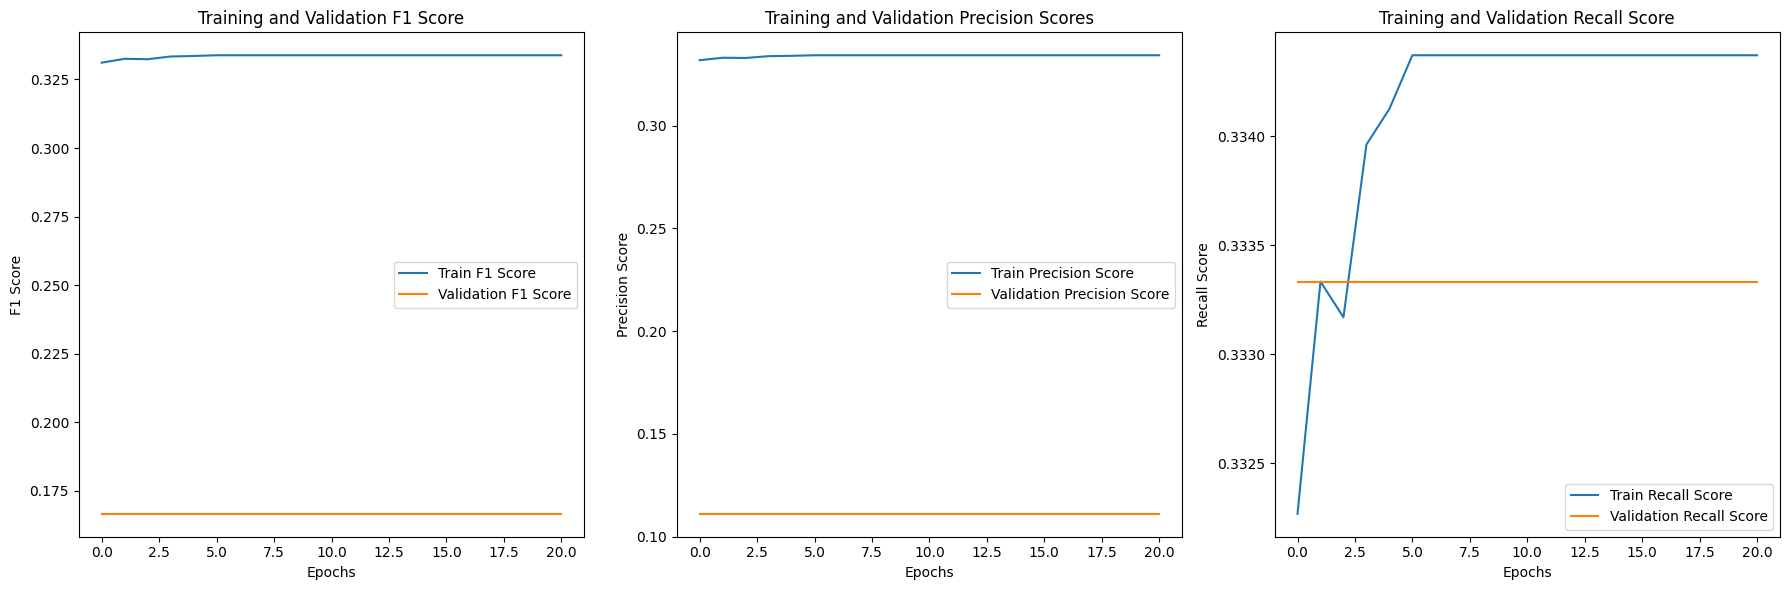


**** TRAINING FOR LEARNING RATE 0.001 ****

Epoch 1/80, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.34, Train Precision: 0.37, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/80, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.42, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/80, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.

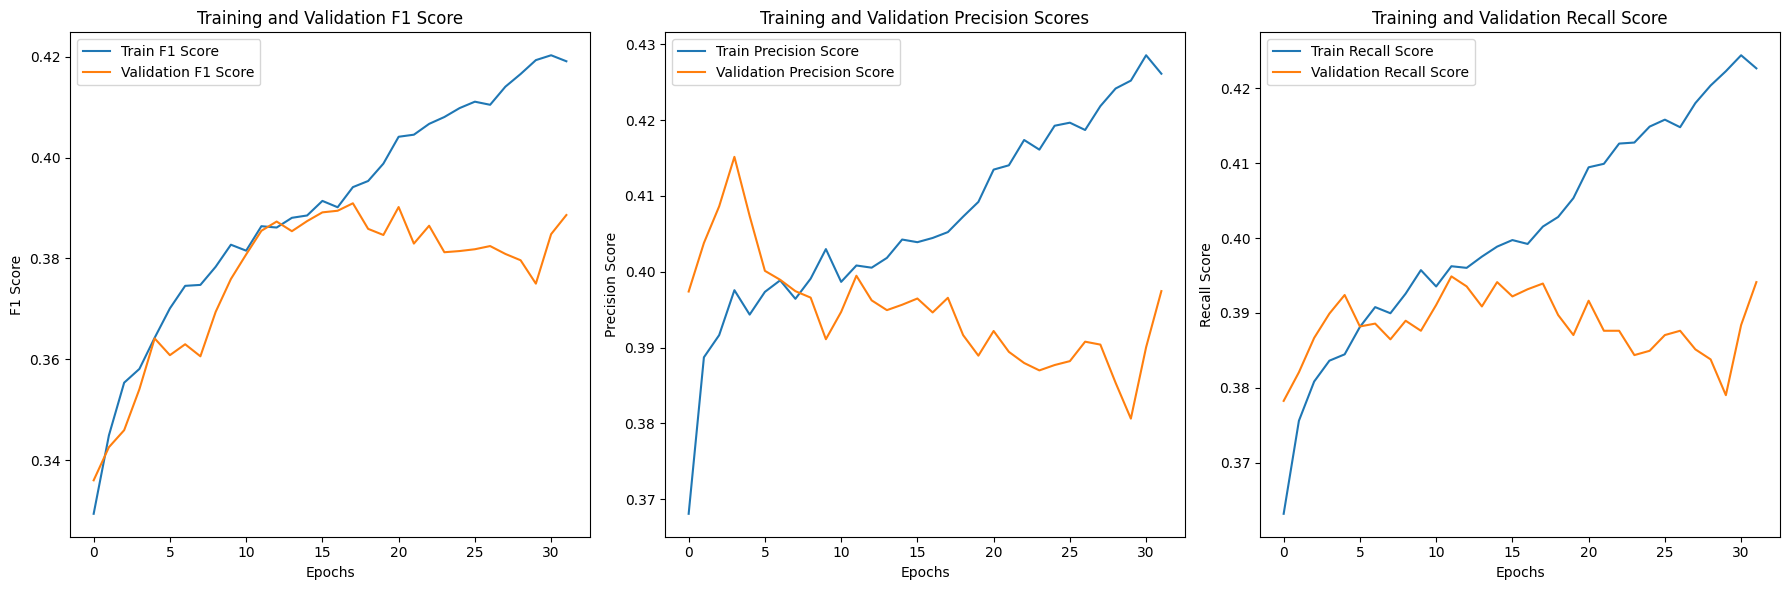


**** TRAINING FOR LEARNING RATE 0.0001 ****

Epoch 1/80, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.35, Valid Precision: 0.37, Train Recall: 0.35, Valid Recall: 0.37
Epoch 2/80, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.38, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.37
Epoch 3/80, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.36, Train Precision: 0.38, Valid Precision: 0.39, Train Recall: 0.37, Valid Recall: 0.38
Epoch 4/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/80, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0

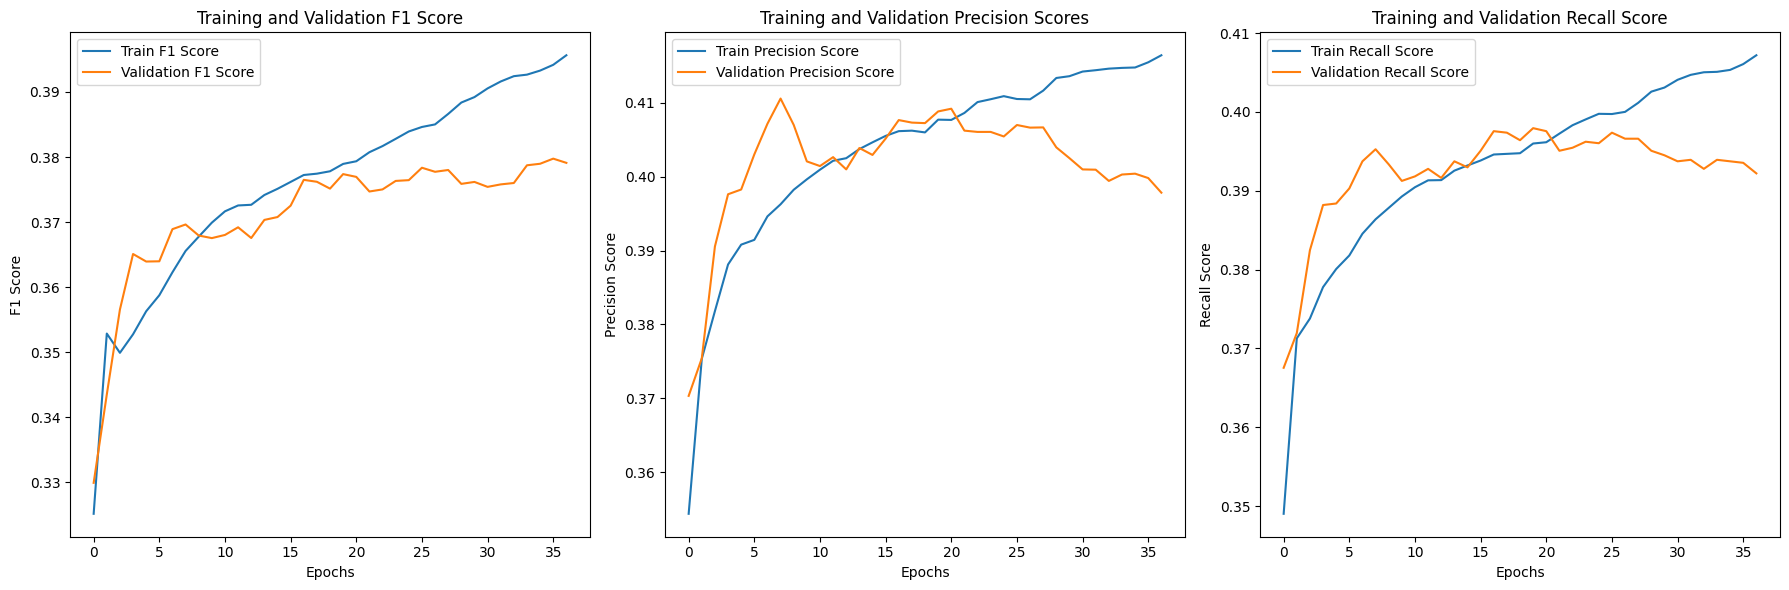


**** TRAINING FOR LEARNING RATE 1e-05 ****

Epoch 1/80, Train Acc: 0.33, Valid Acc: 0.34, Train F1: 0.17, Valid F1: 0.20, Train Precision: 0.22, Valid Precision: 0.26, Train Recall: 0.33, Valid Recall: 0.34
Epoch 2/80, Train Acc: 0.34, Valid Acc: 0.36, Train F1: 0.24, Valid F1: 0.29, Train Precision: 0.38, Valid Precision: 0.41, Train Recall: 0.34, Valid Recall: 0.36
Epoch 3/80, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.30, Valid F1: 0.32, Train Precision: 0.39, Valid Precision: 0.39, Train Recall: 0.36, Valid Recall: 0.37
Epoch 4/80, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.35, Train Precision: 0.37, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.38
Epoch 5/80, Train Acc: 0.37, Valid Acc: 0.39, Train F1: 0.34, Valid F1: 0.37, Train Precision: 0.37, Valid Precision: 0.39, Train Recall: 0.37, Valid Recall: 0.39
Epoch 6/80, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.37, Valid Precision: 0.39, Train Recall: 0.

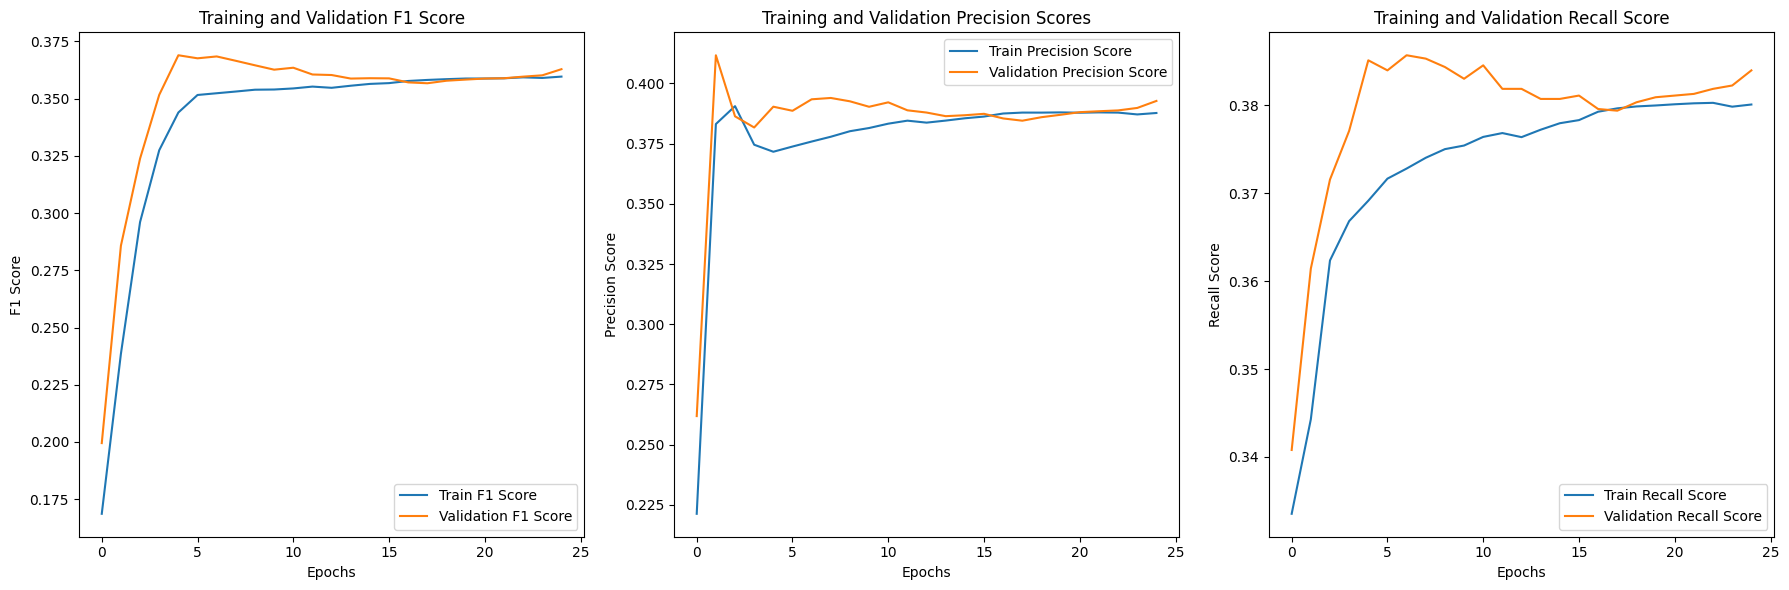

In [90]:
for lr in lr_ls:
    model = Net_5(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f'\n**** TRAINING FOR LEARNING RATE {lr} ****\n')
    train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_early_stopping(model, loss_func, optimizer, num_epochs, train_loader, valid_loader)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h1>Experiments with learning rate scheduler</h1>

<p>Next we conducted experiments with various learning rate schedulers.Learning rate schedulers are used to make learning rate adaptive to the gradient descent optimization procedure, so you can increase performance and reduce training time.</p>

<p>In the neural network training process, data is feed into the network in batches, with many batches in one epoch. Each batch triggers one training step, which the gradient descent algorithm updates the parameters once. However, usually the learning rate schedule is updated once for each training epoch only.</p>

<p>We can update the learning rate as frequent as each step but usually it is updated once per epoch because we want to know how the network performs in order to determine how the learning rate should update. Regularly, a model is evaluated with validation dataset once per epoch.</p>

<p>There are multiple ways of making learning rate adaptive. At the beginning of training, we may prefer a larger learning rate so we improve the network coarsely to speed up the progress. In a very complex neural network model, you may also prefer to gradually increasse the learning rate at the beginning because you need the network to explore on the different dimensions of prediction. At the end of training, however, we always want to have the learning rate smaller. Since at that time, we are about to get the best performance from the model and it is easy to overshoot if the learning rate is large.</p>

<p>Therefore, the simplest and perhaps most used adaptation of the learning rate during training are techniques that reduce the learning rate over time. These have the benefit of making large changes at the beginning of the training procedure when larger learning rate values are used and decreasing the learning rate so that a smaller rate and, therefore, smaller training updates are made to weights later in the training procedure.</p>

<p> conducted experiments with the StepLR, ExponentialLR and ReduceLROnPlateau schedulers.</p>

<p><b>StepLR scheduler</b>: This scheduler led to steady improvements in all metrics over epochs. The early stopping was triggered after 30 epochs, with a mean training and validation accuracy of 0.40, and mean F1 scores of 0.38. The improvement pattern is consistent and gradual, which is a good sign of effective learning.</p>

<p><b>ExponentialLR scheduler</b>: With the ExponentialLR, we achieved slightly better results compared to StepLR. The early stopping was triggered after 35 epochs, but the mean training accuracy reached 0.41, and the mean training F1 score was 0.40. This suggests a more effective learning process, possibly due to the more dynamic adjustment of the learning rate.</p>

<p><b>ReduceLROnPlateau scheduler</b>:This scheduler shows a similar performance to the StepLR, with early stopping triggered after 38 epochs. The mean metrics are comparable to those achieved with the StepLR, suggesting that it didn't offer a significant advantage in this case.</p>

<p><b>Best result</b>: Based on these observations, the ExponentialLR Scheduler seems to be the most effective for our neural network model. It leads to slightly better performance metrics in a comparable number of epochs. The ExponentialLR Scheduler continuously decays the learning rate over epochs, allowing for finer adjustments as the training progresses. This can be especially useful for converging to an optimal solution more effectively in complex models and datasets.</p>


In [18]:
def train_with_scheduler(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader):

    train_acc, valid_acc = [], []
    train_f1, valid_f1 = [], []
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []
    best_valid_f1 = 0
    epochs_no_improve = 0
    patience = 20
    
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.long())
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc.append(accuracy_score(train_labels, train_preds))
        train_f1.append(f1_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_precision.append(precision_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_recall.append(recall_score(train_labels, train_preds, average='weighted', zero_division=0))

        # Validation phase
        model.eval()
        valid_loss = 0
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = loss_func(outputs, labels.long())
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valid_preds.extend(predicted.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        valid_acc.append(accuracy_score(valid_labels, valid_preds))
        valid_f1.append(f1_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_precision.append(precision_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_recall.append(recall_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)  # Example if using validation loss
        else:
            scheduler.step()
            
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Acc: {train_acc[-1]:.2f}, Valid Acc: {valid_acc[-1]:.2f}, '
              f'Train F1: {train_f1[-1]:.2f}, Valid F1: {valid_f1[-1]:.2f}, '
              f'Train Precision: {train_precision[-1]:.2f}, Valid Precision: {valid_precision[-1]:.2f}, '
              f'Train Recall: {train_recall[-1]:.2f}, Valid Recall: {valid_recall[-1]:.2f}')

        temp_f1 = round(valid_f1[-1], 2)
        if temp_f1 > best_valid_f1:
            best_valid_f1 = temp_f1
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    print(f'MEAN TRAIN ACCURACY: {np.mean(train_acc):.2f}\n'
          f'MEAN VALIDATION ACCURACY: {np.mean(valid_acc):.2f}\n'
          f'MEAN TRAIN F1 SCORE: {np.mean(train_f1):.2f}\n'
          f'MEAN VALIDATION F1 SCORE: {np.mean(valid_f1):.2f}\n'
          f'MEAN TRAIN PRECISION: {np.mean(train_precision):.2f}\n'
          f'MEAN VALIDATION PRECISION: {np.mean(valid_precision):.2f}\n'
          f'MEAN TRAIN RECALL: {np.mean(train_recall):.2f}\n'
          f'MEAN VALIDATION RECALL: {np.mean(valid_recall):.2f}\n')
    return train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision

In [18]:
# We construct a nn with 4 hidden layers
class Net_6(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_6, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR SCHEDULER StepLR **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.42, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, V

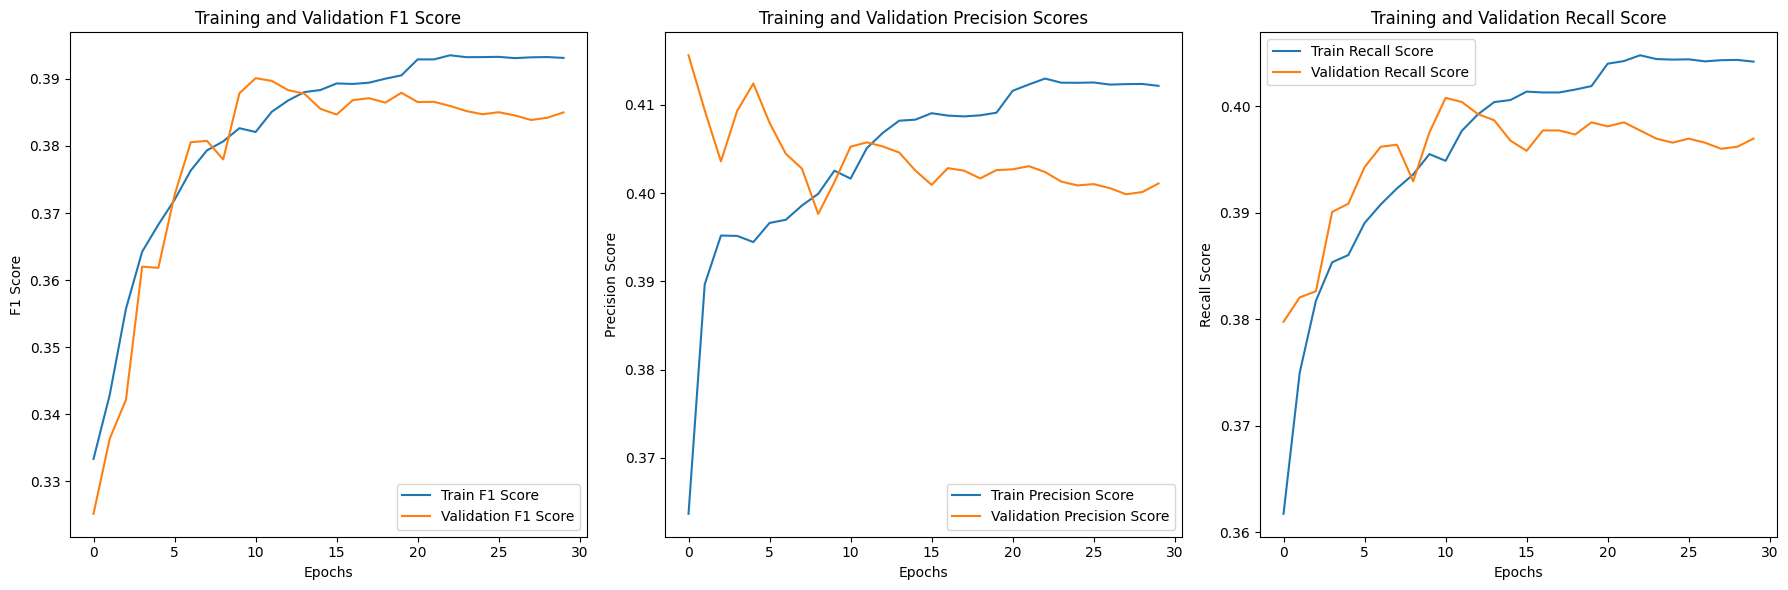


**** FOR SCHEDULER ExponentialLR **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.34, Train Precision: 0.37, Valid Precision: 0.39, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.38, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.40, Train F1: 0.37, Valid F1: 0.38, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 

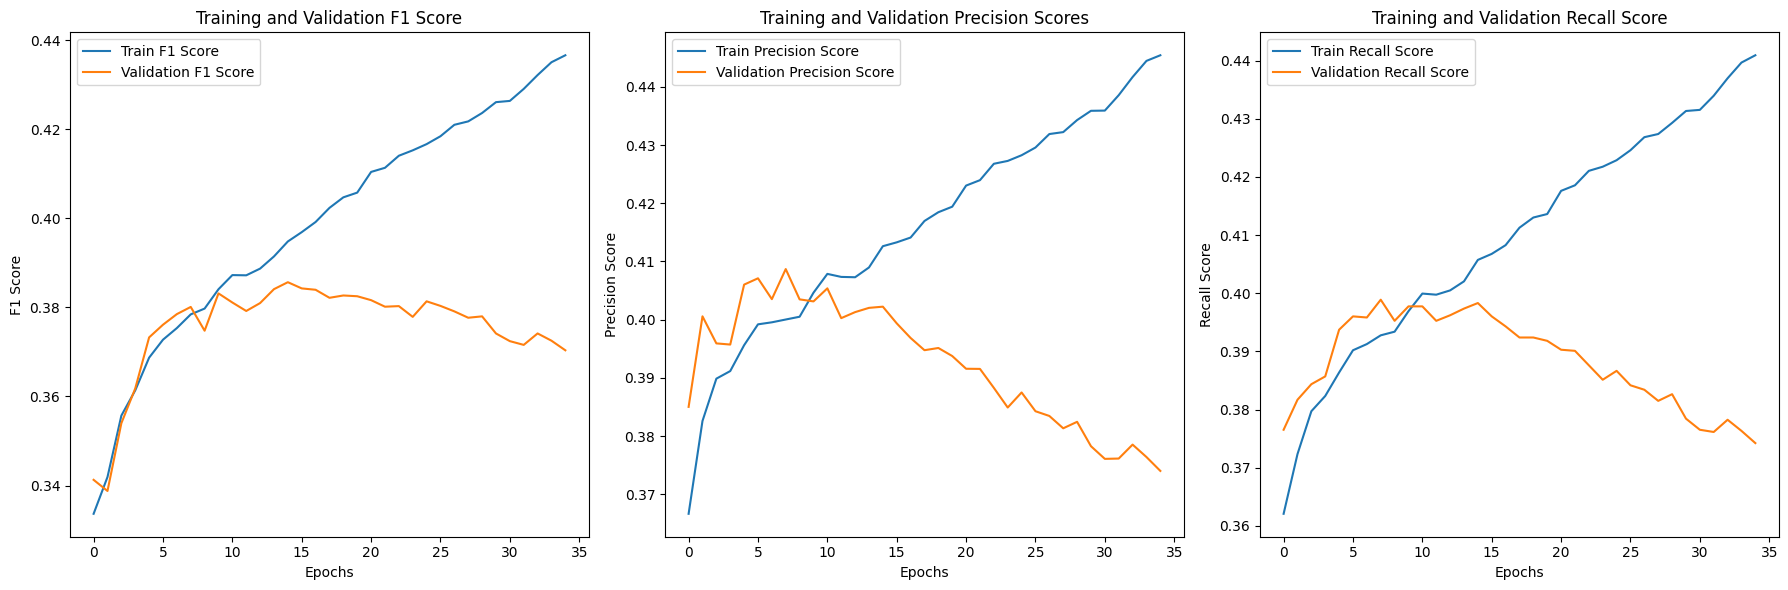


**** FOR SCHEDULER ReduceLROnPlateau **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.35, Train Precision: 0.37, Valid Precision: 0.39, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.40, Train F1: 0.37, Valid F1: 0.38, Train Precision: 0.40, Valid Precision: 0.40, Train Reca

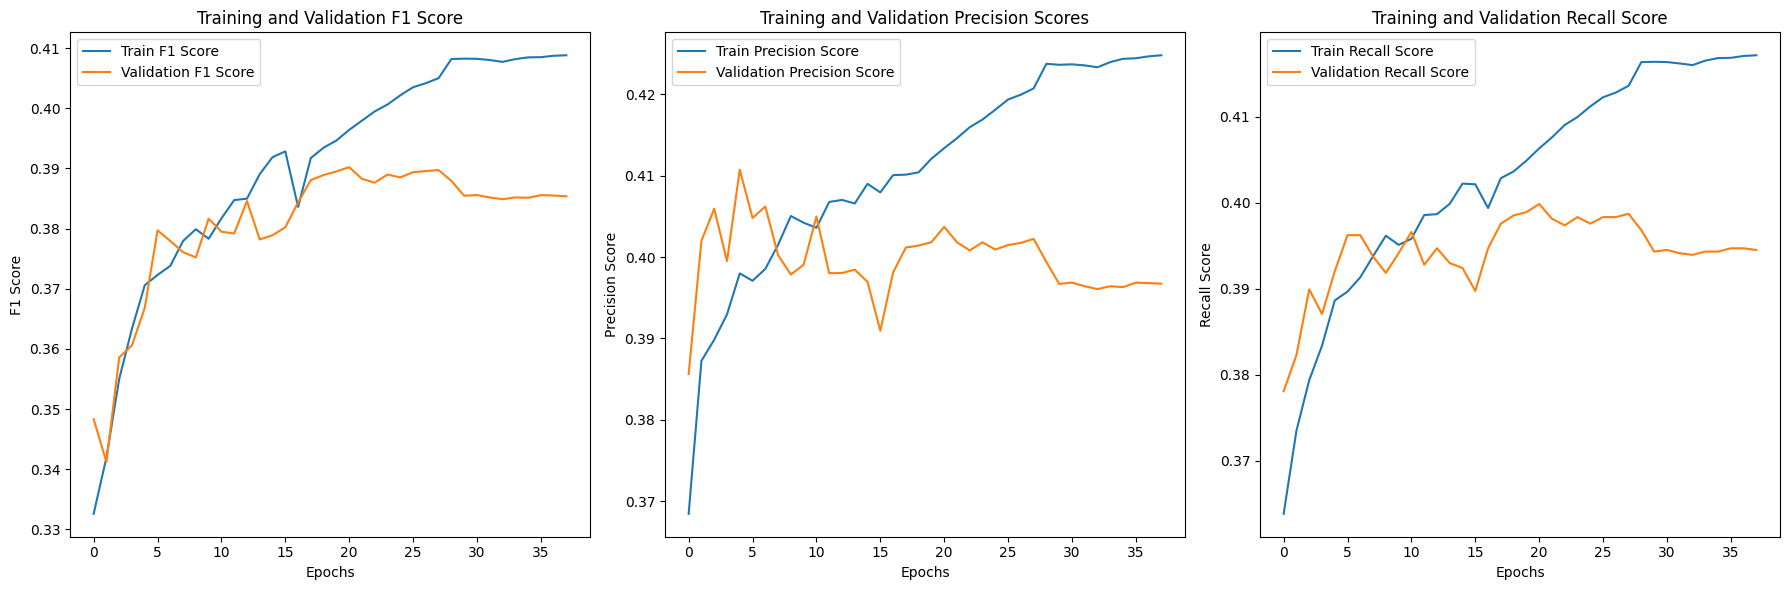

In [23]:
# StepLR
model = Net_6(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # reduce every 10 epochs
print('\n**** FOR SCHEDULER StepLR **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_scheduler(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

# ExponentialLR
model = Net_6(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3) # reinittialize
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print('\n**** FOR SCHEDULER ExponentialLR **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_scheduler(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)


# ReduceLROnPlateau
model = Net_6(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3) # reinittialize
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
print('\n**** FOR SCHEDULER ReduceLROnPlateau **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_scheduler(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h1>Experiments with batch size</h1>

<p>Batch size is one of the most important hyperparameters in deep learning training, and it represents the number of samples used in one forward and backward pass through the network and has a direct impact on the accuracy and computational efficiency of the training process. The batch size can be understood as a trade-off between accuracy and speed. Large batch sizes can lead to faster training times but may result in lower accuracy and overfitting, while smaller batch sizes can provide better accuracy, but can be computationally expensive and time-consuming.</p>

<p>The batch size can also affect the convergence of the model, meaning that it can influence the optimization process and the speed at which the model learns. Small batch sizes can be more susceptible to random fluctuations in the training data, while larger batch sizes are more resistant to these fluctuations but may converge more slowly.</p>

<p>It is important to note that there is no one-size-fits-all answer when it comes to choosing a batch size, as the ideal size will depend on several factors, including the size of the training dataset, the complexity of the model, and the computational resources available.</p>

<p>We did experiments with batch size equal with 8, 12, 32, 64, 128. Based on the results we received from each experiments we concluded to the following observations:</p>

<p><b>Batch size 8</b>: Achieved the highest mean training accuracy (0.42) and f1 score (0.41). Early stopping was triggered after 52 epochs, indicating a slower convergence. This batch size leads to more frequent updates, which can help in better generalization but might be computationally expensive.</p>

<p><b>Batch size 12</b>: Slightly lower mean training accuracy (0.40) and f1 score (0.39) compared to batch size 8. Early stopping was triggered after 34 epochs, faster than batch size 8. Offers a balance between update frequency and computational demand.</p>

<p><b>Batch size 32</b>: Comparable performance to batch size 12 with a mean training accuracy of 0.41 and f1 score of 0.40. Early stopping was triggered after 35 epochs. Larger batch size can lead to more stable gradient updates but might reduce model's ability to generalize.</p>

<p><b>Batch size 64 and 128</b>: Both show similar trends in training accuracy and f1 score, hovering around 0.40 and 0.39 respectively. Early stopping was triggered sooner (29 epochs for batch size 64 and 31 for batch size 128) than smaller batch sizes. Larger batches lead to quicker convergence but might miss out on finer features due to averaging effect in gradient calculation.</p>

<p><b>Best result</b>: Based on the values we got for mean training-validation accuracy, f1, precision and recall we choose to use batch size equal to 8.</p>

https://www.sabrepc.com/blog/Deep-Learning-and-AI/Epochs-Batch-Size-Iterations

In [14]:
def train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader):

    train_acc, valid_acc = [], []
    train_f1, valid_f1 = [], []
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []
    best_valid_f1 = 0
    epochs_no_improve = 0
    patience = 20
    
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.long())
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc.append(accuracy_score(train_labels, train_preds))
        train_f1.append(f1_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_precision.append(precision_score(train_labels, train_preds, average='weighted', zero_division=0))
        train_recall.append(recall_score(train_labels, train_preds, average='weighted', zero_division=0))

        # Validation phase
        model.eval()
        valid_loss = 0
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = loss_func(outputs, labels.long())
                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                valid_preds.extend(predicted.cpu().numpy())
                valid_labels.extend(labels.cpu().numpy())

        valid_acc.append(accuracy_score(valid_labels, valid_preds))
        valid_f1.append(f1_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_precision.append(precision_score(valid_labels, valid_preds, average='weighted', zero_division=0))
        valid_recall.append(recall_score(valid_labels, valid_preds, average='weighted', zero_division=0))

        scheduler.step()
            
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Acc: {train_acc[-1]:.2f}, Valid Acc: {valid_acc[-1]:.2f}, '
              f'Train F1: {train_f1[-1]:.2f}, Valid F1: {valid_f1[-1]:.2f}, '
              f'Train Precision: {train_precision[-1]:.2f}, Valid Precision: {valid_precision[-1]:.2f}, '
              f'Train Recall: {train_recall[-1]:.2f}, Valid Recall: {valid_recall[-1]:.2f}')

        temp_f1 = round(valid_f1[-1], 2)
        if temp_f1 > best_valid_f1:
            best_valid_f1 = temp_f1
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    print(f'MEAN TRAIN ACCURACY: {np.mean(train_acc):.2f}\n'
          f'MEAN VALIDATION ACCURACY: {np.mean(valid_acc):.2f}\n'
          f'MEAN TRAIN F1 SCORE: {np.mean(train_f1):.2f}\n'
          f'MEAN VALIDATION F1 SCORE: {np.mean(valid_f1):.2f}\n'
          f'MEAN TRAIN PRECISION: {np.mean(train_precision):.2f}\n'
          f'MEAN VALIDATION PRECISION: {np.mean(valid_precision):.2f}\n'
          f'MEAN TRAIN RECALL: {np.mean(train_recall):.2f}\n'
          f'MEAN VALIDATION RECALL: {np.mean(valid_recall):.2f}\n')
    return train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision

In [20]:
class Net_7(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_7, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x

In [20]:
batch_size_ls = [8, 12, 32, 64, 128]


**** FOR BATCH SIZE 8 **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.36, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.39, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.39, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid

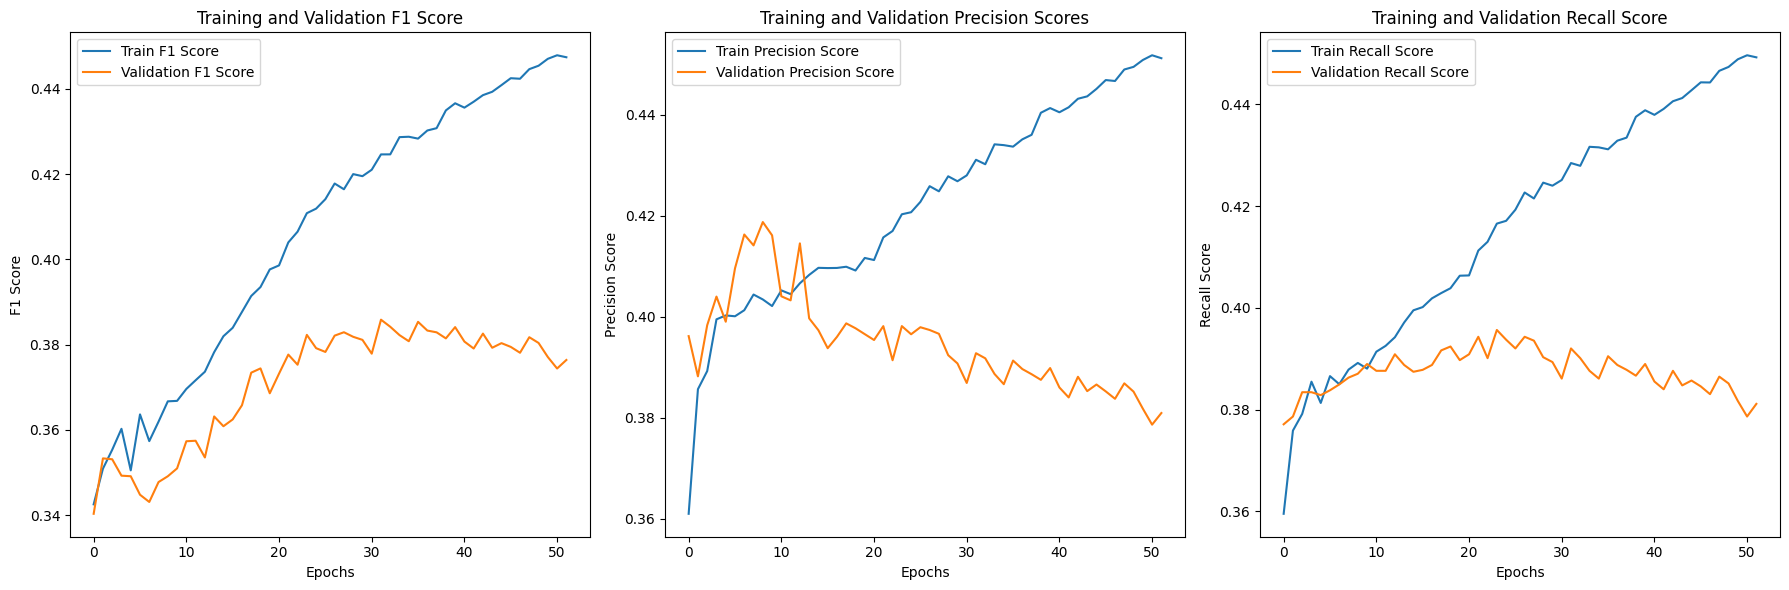


**** FOR BATCH SIZE 12 **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.31, Train Precision: 0.36, Valid Precision: 0.42, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.42, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Vali

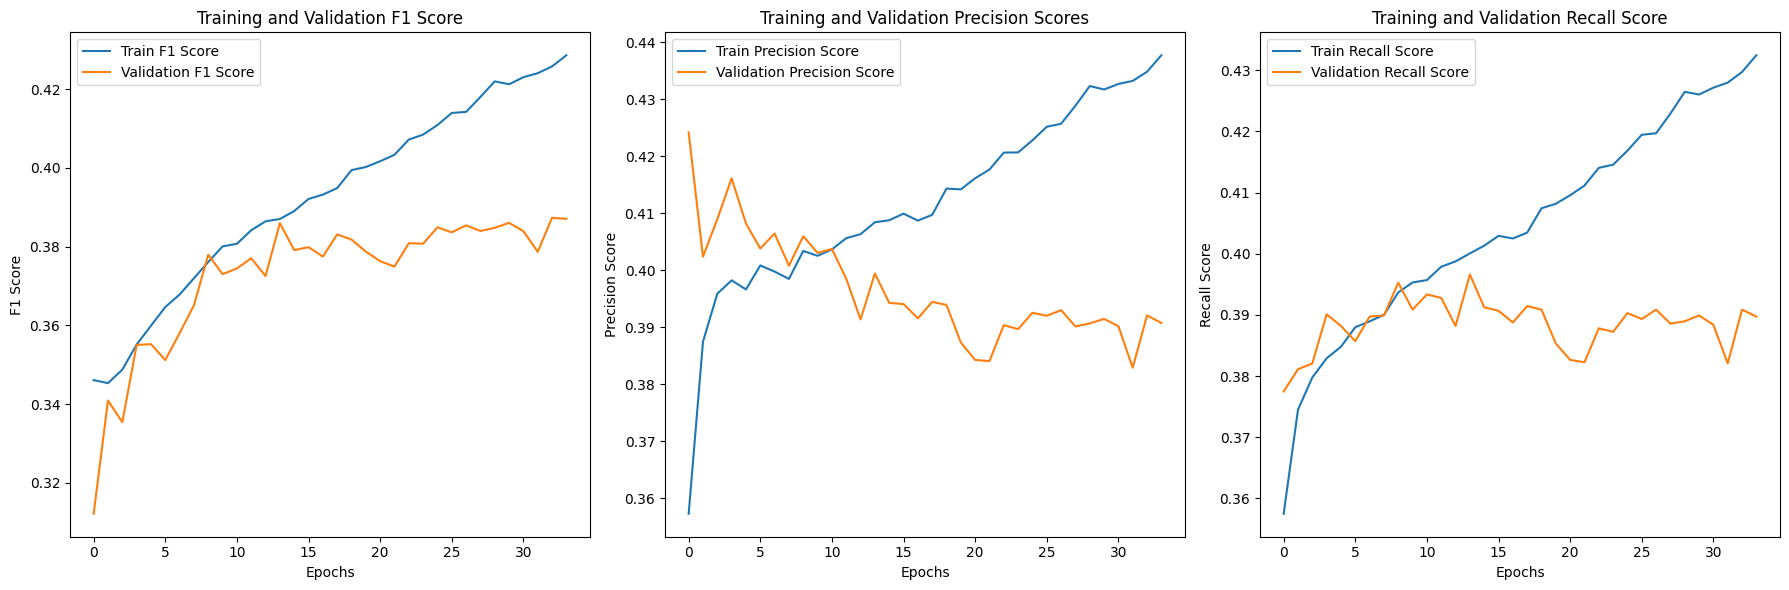


**** FOR BATCH SIZE 32 **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.32, Train Precision: 0.37, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Vali

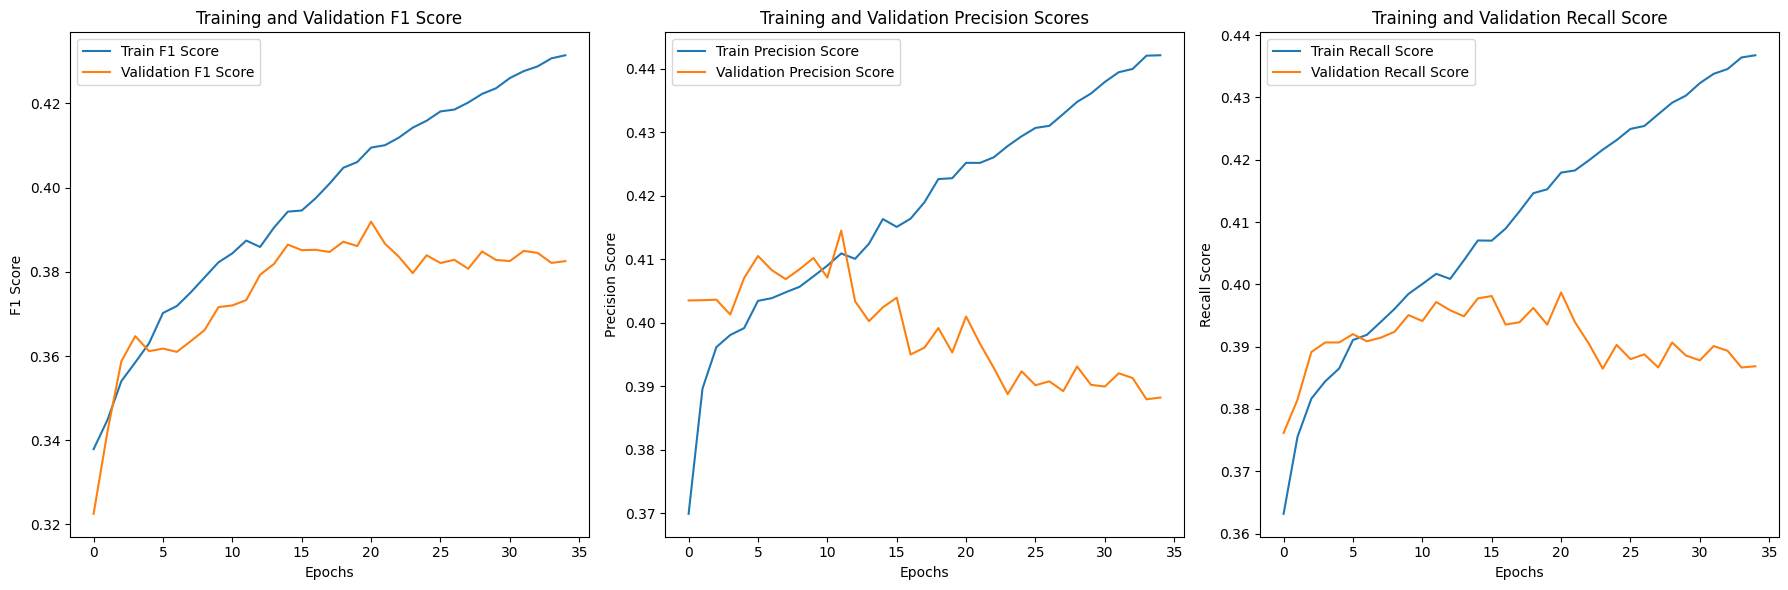


**** FOR BATCH SIZE 64 **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.39, Train F1: 0.34, Valid F1: 0.35, Train Precision: 0.36, Valid Precision: 0.41, Train Recall: 0.36, Valid Recall: 0.39
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.39, Train Recall: 0.38, Valid Recall: 0.39
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.39, Vali

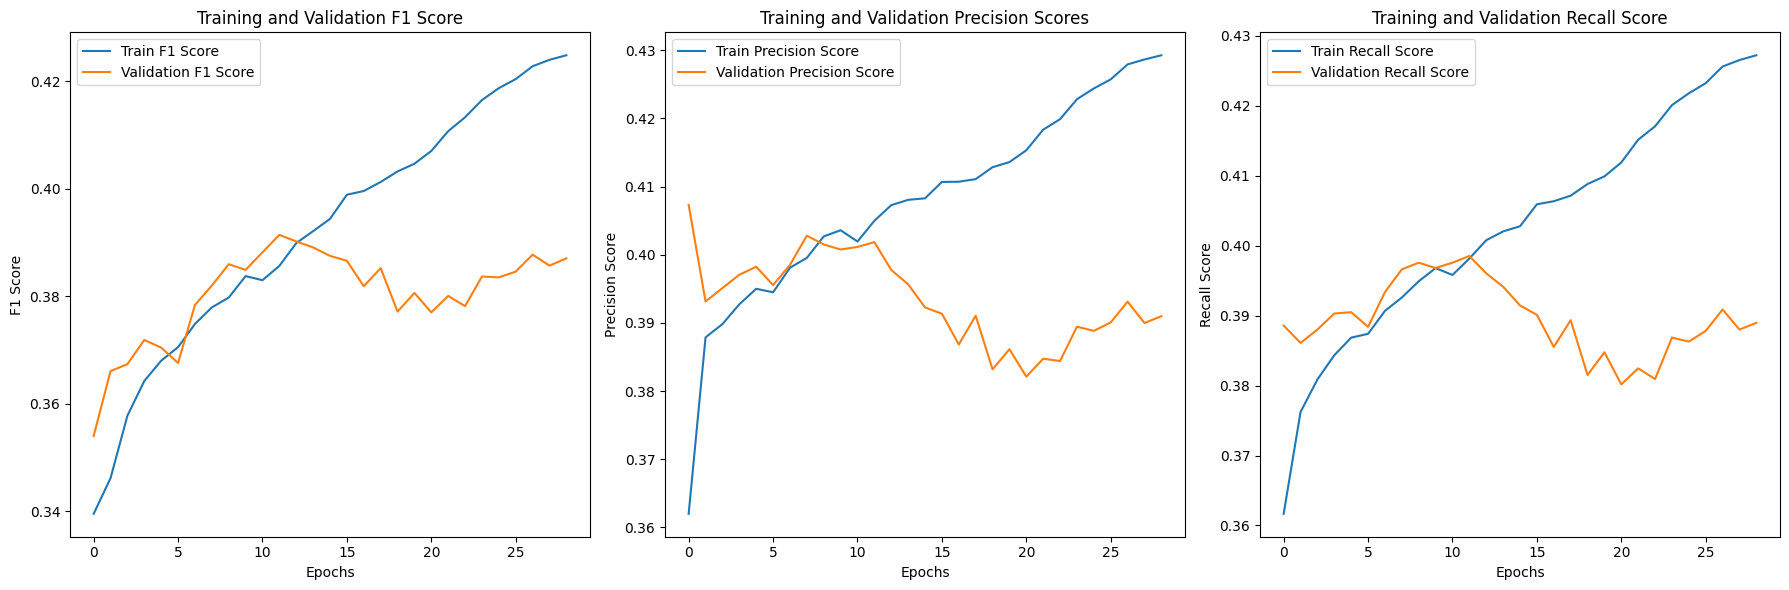


**** FOR BATCH SIZE 128 **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.36, Valid Precision: 0.39, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.39, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Val

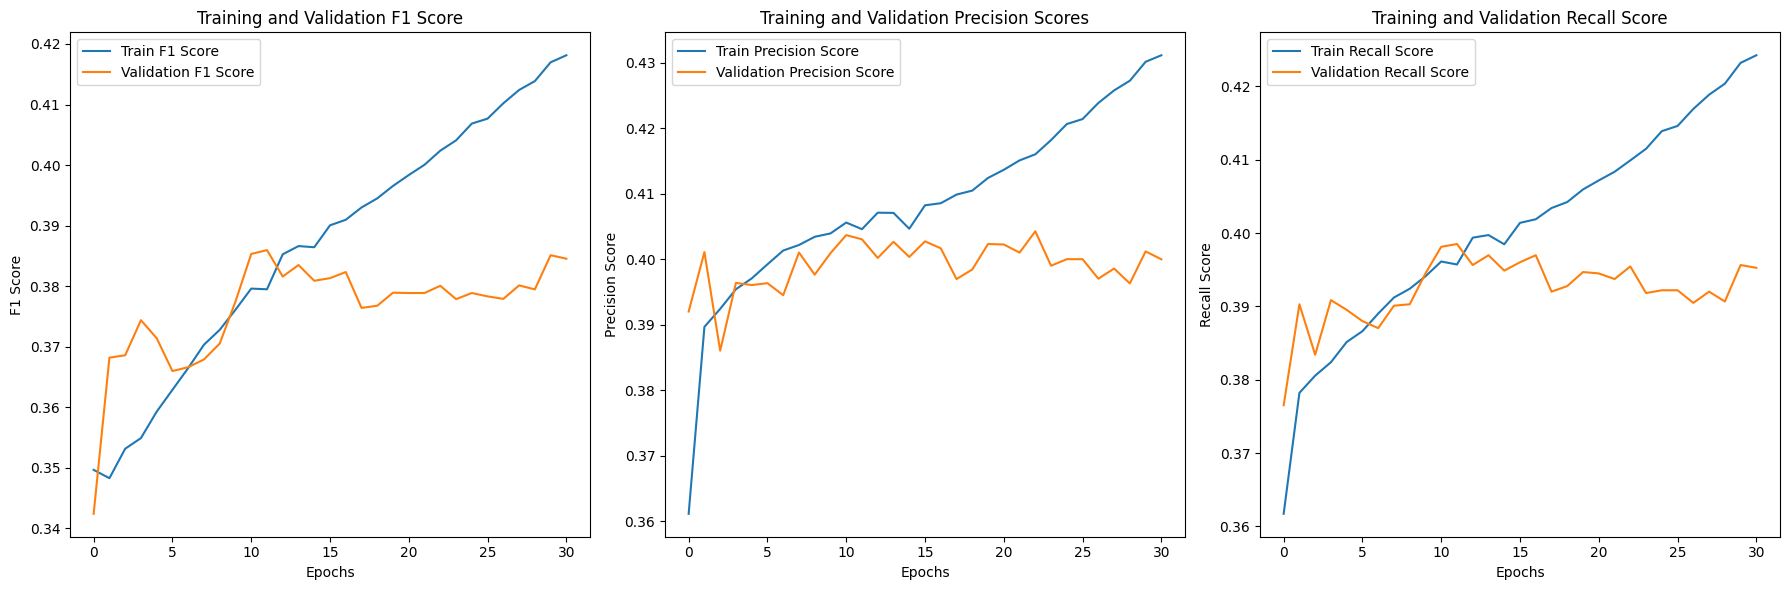

In [21]:
for batch in batch_size_ls:
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False)
    
    model = Net_7(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3) # reinittialize
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    print(f'\n**** FOR BATCH SIZE {batch} **** \n')
    train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
    plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h1>Experimens with activation functions</h1>

<p>Activation function of a node in an artificial neural network is a function that calculates the output of the node (based on its inputs and the weights on individual inputs). Nontrivial problems can be solved only using a nonlinear activation function. Modern activation functions include the smooth version of the ReLU, the GELU</p>

https://en.wikipedia.org/wiki/Activation_function

<p><b>Sigmoid</b>: It showed a gradual improvement over epochs but still had relatively low performance metrics. Sigmoid functions often suffer from the vanishing gradient problem, especially in deeper networks.</p>

<p><b>Tanh</b>: This activation function provided slightly better results than Sigmoid. Tanh is similar to Sigmoid but ranges from -1 to 1, providing stronger gradients for negative values compared to Sigmoid. However, it still suffers from the vanishing gradient problem.</p>

<p><b>Leaky ReLU</b>: This function showed a significant improvement over Sigmoid and Tanh, especially in terms of F1 score, precision, and recall. Leaky ReLU helps in preventing the dying ReLU problem by allowing a small gradient when the unit is not active.</p>

<p><b>Parametric ReLU (PReLU)</b>: The performance of PReLU is comparable to Leaky ReLU, with slightly better F1 scores and precision in some epochs. PReLU introduces a learnable parameter which allows adaptation during training, potentially leading to better performance.</p>

<p><b>Exponential Linear Unit (ELU</b> ELU also provided good results, similar to Leaky ReLU and PReLU. ELU can help converge cost to zero faster and produce more accurate results. It tends to outperform other ReLU variants, especially in deeper networks.</p>

<p><b>Softmax</b>: The use of Softmax in hidden layers resulted in significantly lower performance metrics across all categories. Softmax is typically used in the output layer for multi-class classification tasks and is not suitable for hidden layers as it normalizes layer outputs to a probability distribution, which is not beneficial in this context.</p>

<p><b>ReLU</b>ReLU shows a consistent slight improvement in training accuracy, f1 score, precision, and recall over the epochs. It demonstrates a decent performance among the activation functions we tested, with a balanced improvement across all metrics.
</p>

<p><b>ReLU and Softmax at the output layer</b>: Both training and validation accuracy improve gradually over epochs, indicating that the model is learning effectively. The mean training accuracy reaches 0.40, and the mean validation accuracy is 0.39, suggesting a good fit without significant overfitting. Similarly, the f1 score, which is a more robust measure than accuracy in many cases, also shows a stable increase.</p>

<p>Based on these results, Leaky ReLU, PReLU, ELU and ReLU seem to be the best performing activation functions for your network. They consistently show higher accuracy, precision, recall, and F1 scores compared to Sigmoid, Tanh, and Softmax.</p>


<p>Among these, <b>ReLU</b> shows a slightly better average in terms of train accuracy and f1 scores compared to Leaky ReLU, PReLU and ELU. However, the differences are not substantial, and all three perform similarly well.</p>

<h2>Sigmoid</h2>

In [23]:
class Net_8(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_8, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.Sigmoid()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.Sigmoid()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.Sigmoid()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.Sigmoid()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR SIGMOID **** 

Epoch 1/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.32, Train Precision: 0.35, Valid Precision: 0.36, Train Recall: 0.35, Valid Recall: 0.37
Epoch 2/100, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.38, Train Recall: 0.36, Valid Recall: 0.37
Epoch 3/100, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.32, Train Precision: 0.37, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.37
Epoch 4/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.39, Train Recall: 0.38, Valid Recall: 0.38
Epoch 6/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.39, Train Recall: 0.38, Valid Reca

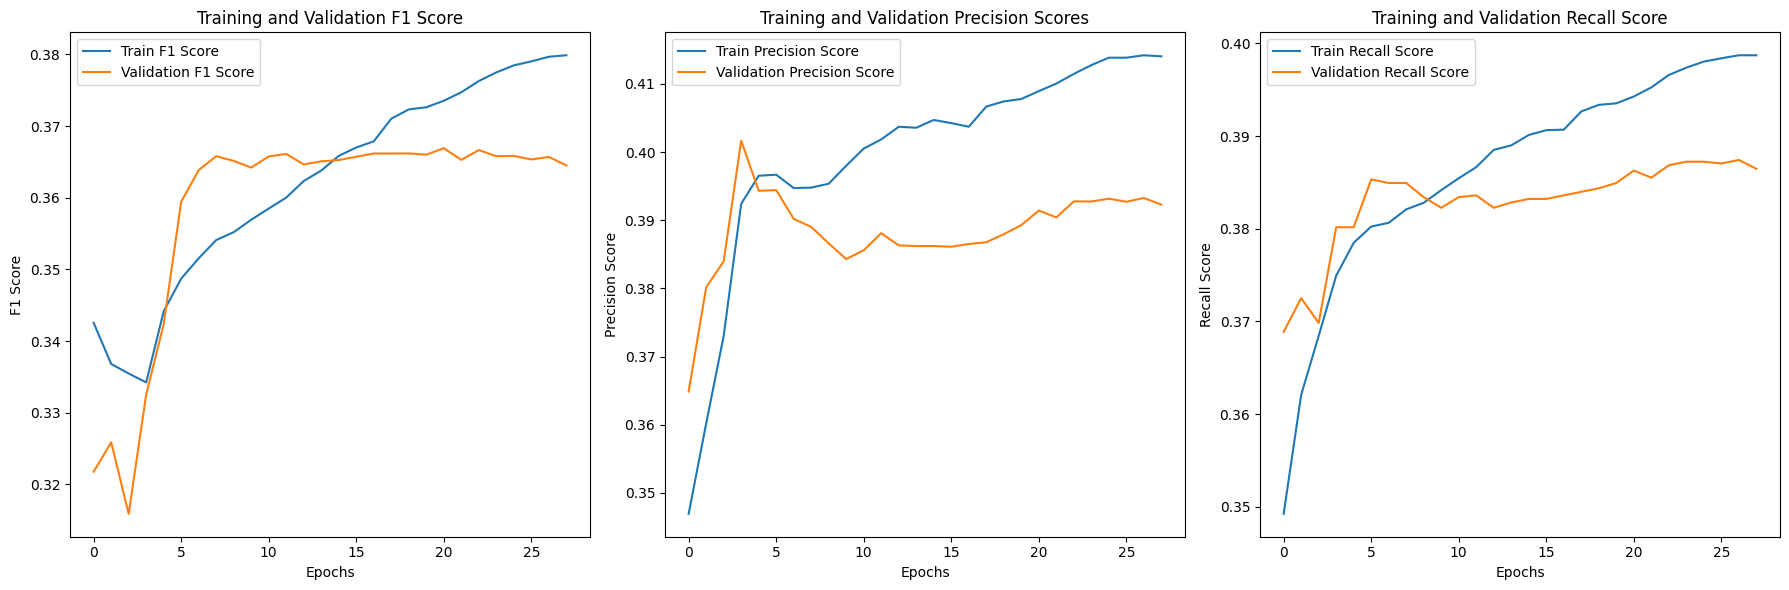

In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_8(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3) # reinittialize
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR SIGMOID **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Tanh</h2>

In [25]:
class Net_9(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_9, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.Tanh()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.Tanh()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.Tanh()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.Tanh()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR TANH **** 

Epoch 1/100, Train Acc: 0.35, Valid Acc: 0.36, Train F1: 0.34, Valid F1: 0.31, Train Precision: 0.35, Valid Precision: 0.35, Train Recall: 0.35, Valid Recall: 0.36
Epoch 2/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.28, Train Precision: 0.35, Valid Precision: 0.32, Train Recall: 0.35, Valid Recall: 0.37
Epoch 3/100, Train Acc: 0.36, Valid Acc: 0.34, Train F1: 0.33, Valid F1: 0.18, Train Precision: 0.35, Valid Precision: 0.25, Train Recall: 0.36, Valid Recall: 0.34
Epoch 4/100, Train Acc: 0.34, Valid Acc: 0.35, Train F1: 0.33, Valid F1: 0.23, Train Precision: 0.34, Valid Precision: 0.39, Train Recall: 0.34, Valid Recall: 0.35
Epoch 5/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.32, Train Precision: 0.35, Valid Precision: 0.36, Train Recall: 0.35, Valid Recall: 0.37
Epoch 6/100, Train Acc: 0.35, Valid Acc: 0.36, Train F1: 0.33, Valid F1: 0.26, Train Precision: 0.35, Valid Precision: 0.38, Train Recall: 0.35, Valid Recall:

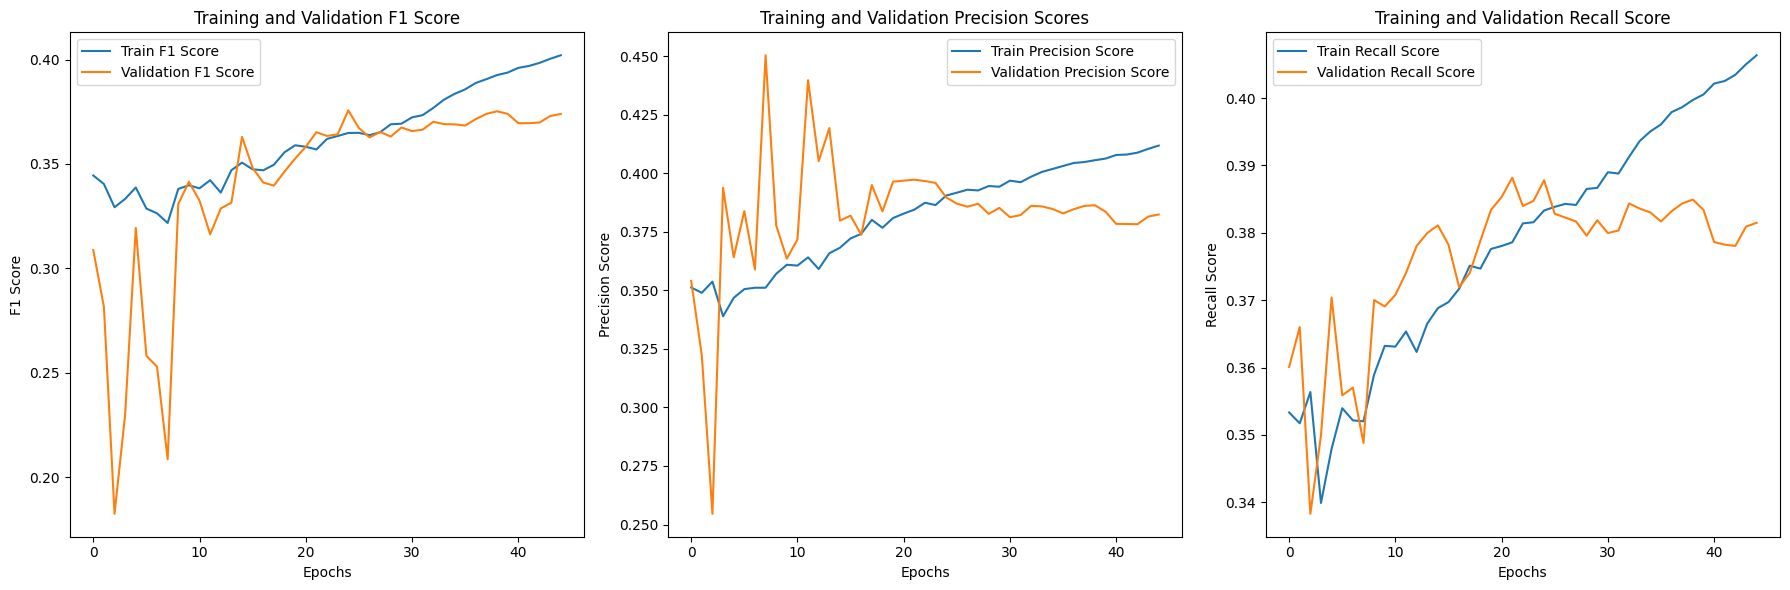

In [26]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_9(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR TANH **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Leaky ReLU</h2>

In [27]:
class Net_10(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_10, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.LeakyReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.LeakyReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR Leaky ReLu **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.41, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid R

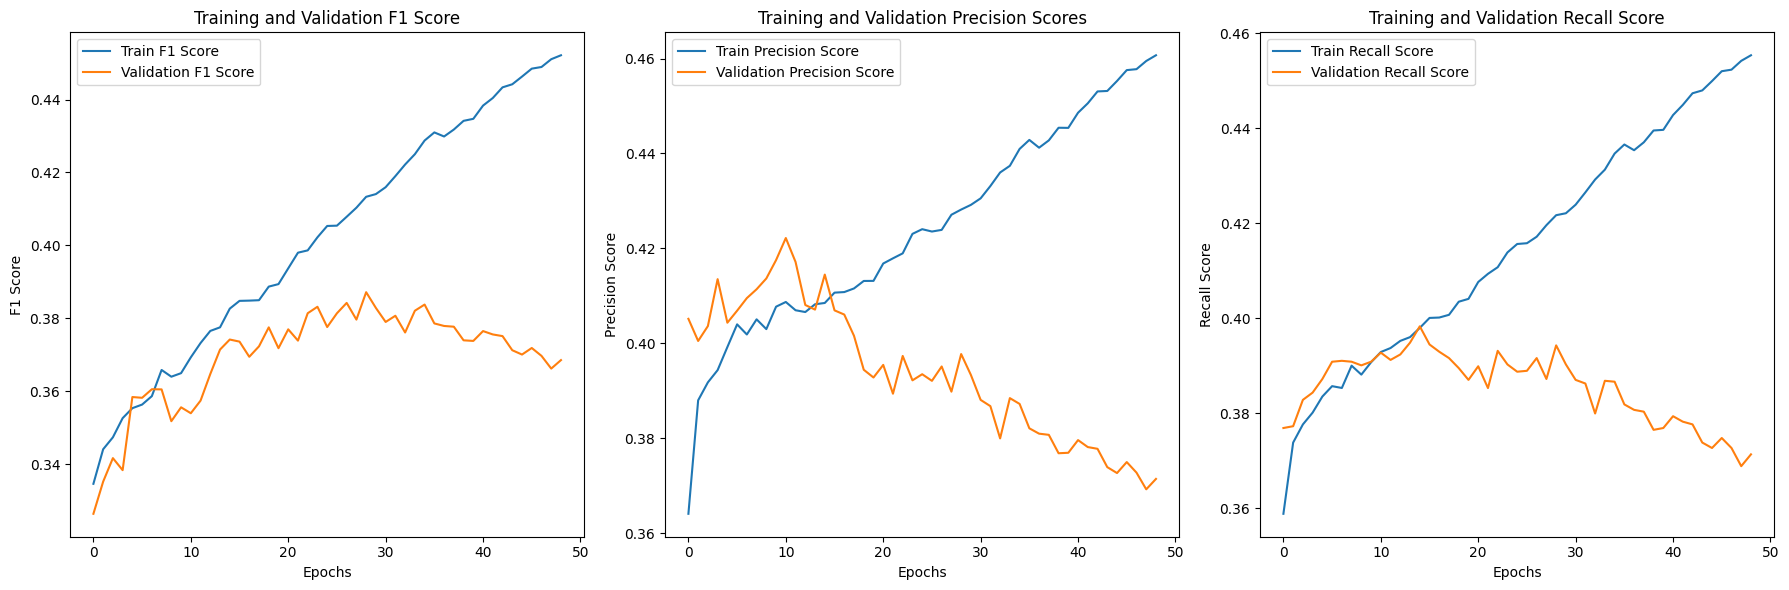

In [28]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_10(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Leaky ReLu **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Parametric ReLU (PReLU)</h2>

In [29]:
class Net_11(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_11, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.PReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.PReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.PReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.PReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR Parametric ReLu **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.41, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.39, Train F1: 0.34, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.39
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.38, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Va

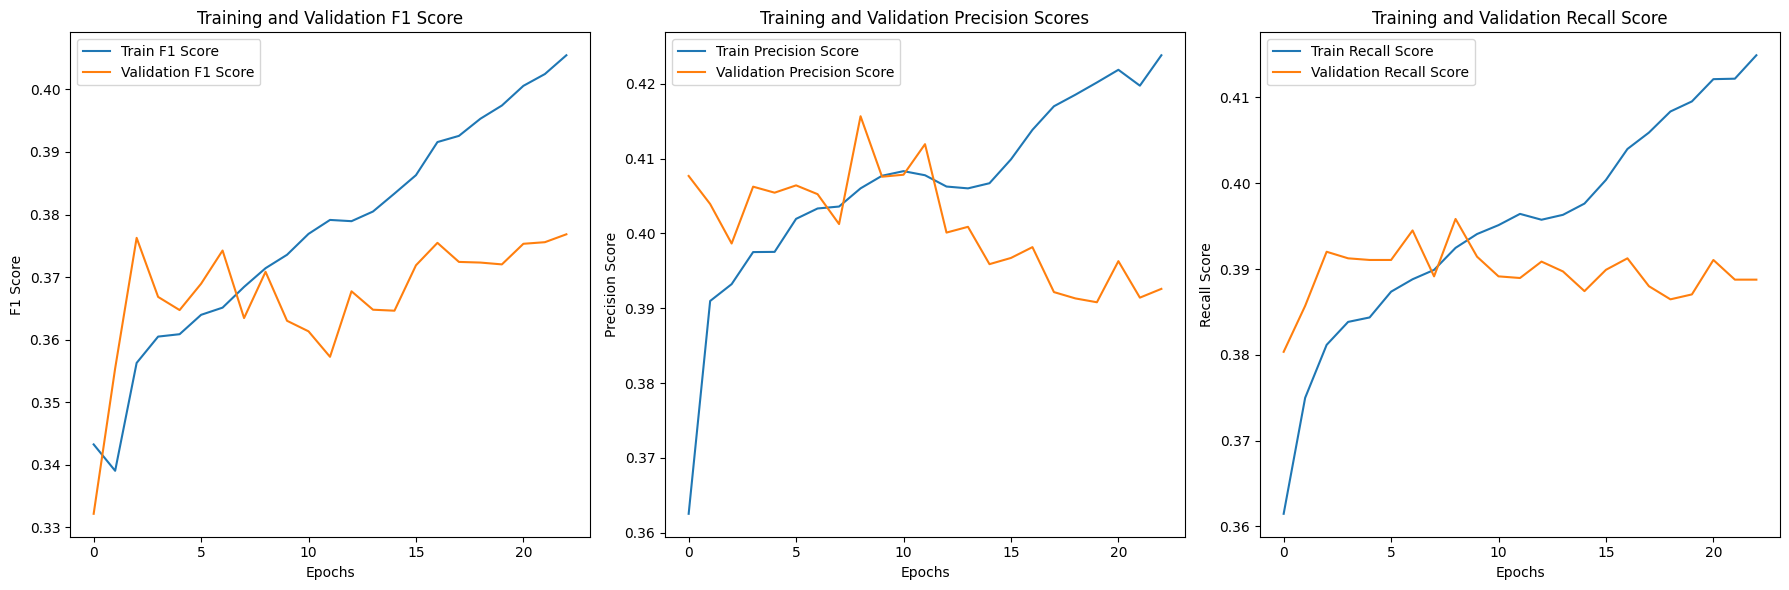

In [30]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_11(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Parametric ReLu **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Exponential Linear Unit (ELU)</h2>

In [31]:
class Net_12(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_12, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.PReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.PReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.PReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.PReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR Exponential Linear Unit (ELU) **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.33, Train Precision: 0.37, Valid Precision: 0.41, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.33, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.33, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Re

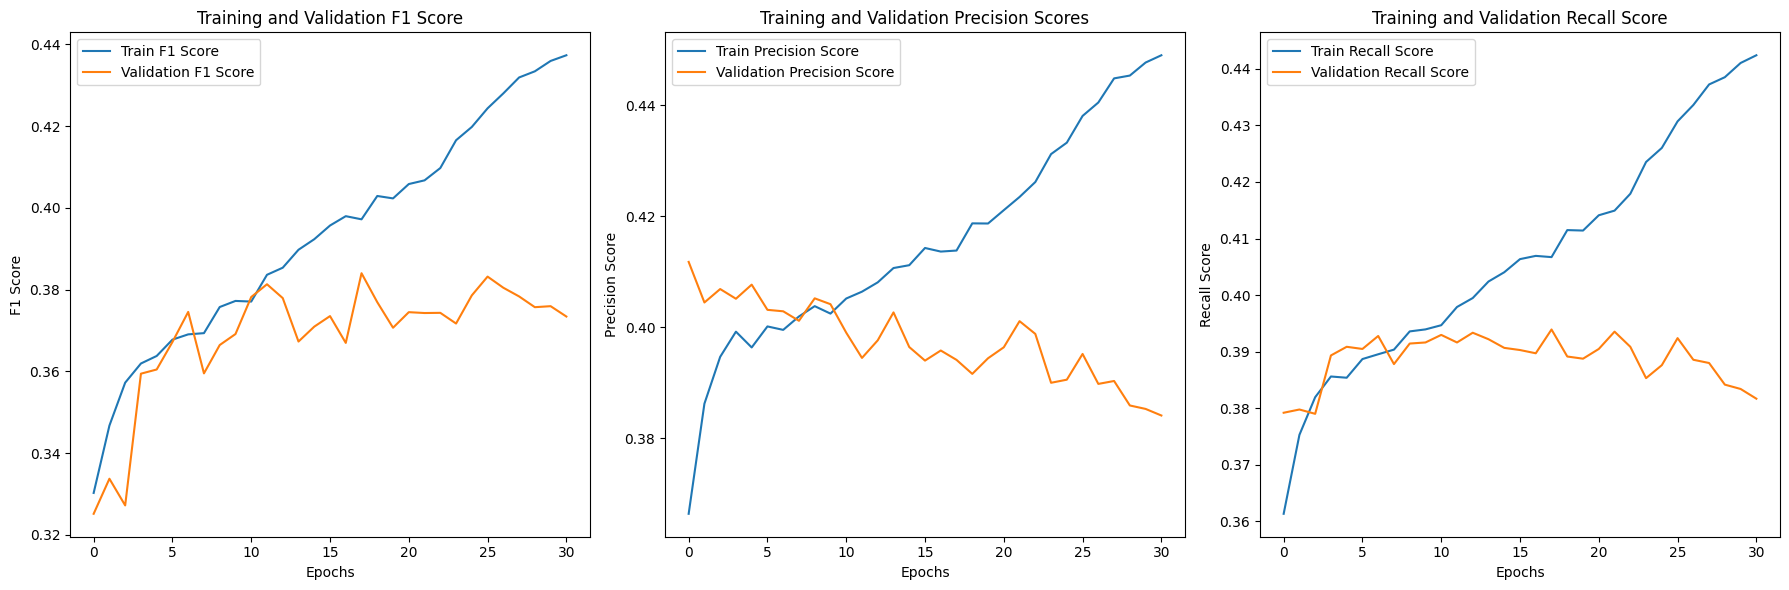

In [32]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_12(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Exponential Linear Unit (ELU) **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Softmax</h2>

In [23]:
class Net_13(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_13, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.Softmax(dim=1)
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.Softmax(dim=1)
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.Softmax(dim=1)
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.Softmax(dim=1)
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR Softmax **** 

Epoch 1/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 2/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 3/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 4/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 5/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Recall: 0.33
Epoch 6/100, Train Acc: 0.33, Valid Acc: 0.33, Train F1: 0.32, Valid F1: 0.17, Train Precision: 0.33, Valid Precision: 0.11, Train Recall: 0.33, Valid Reca

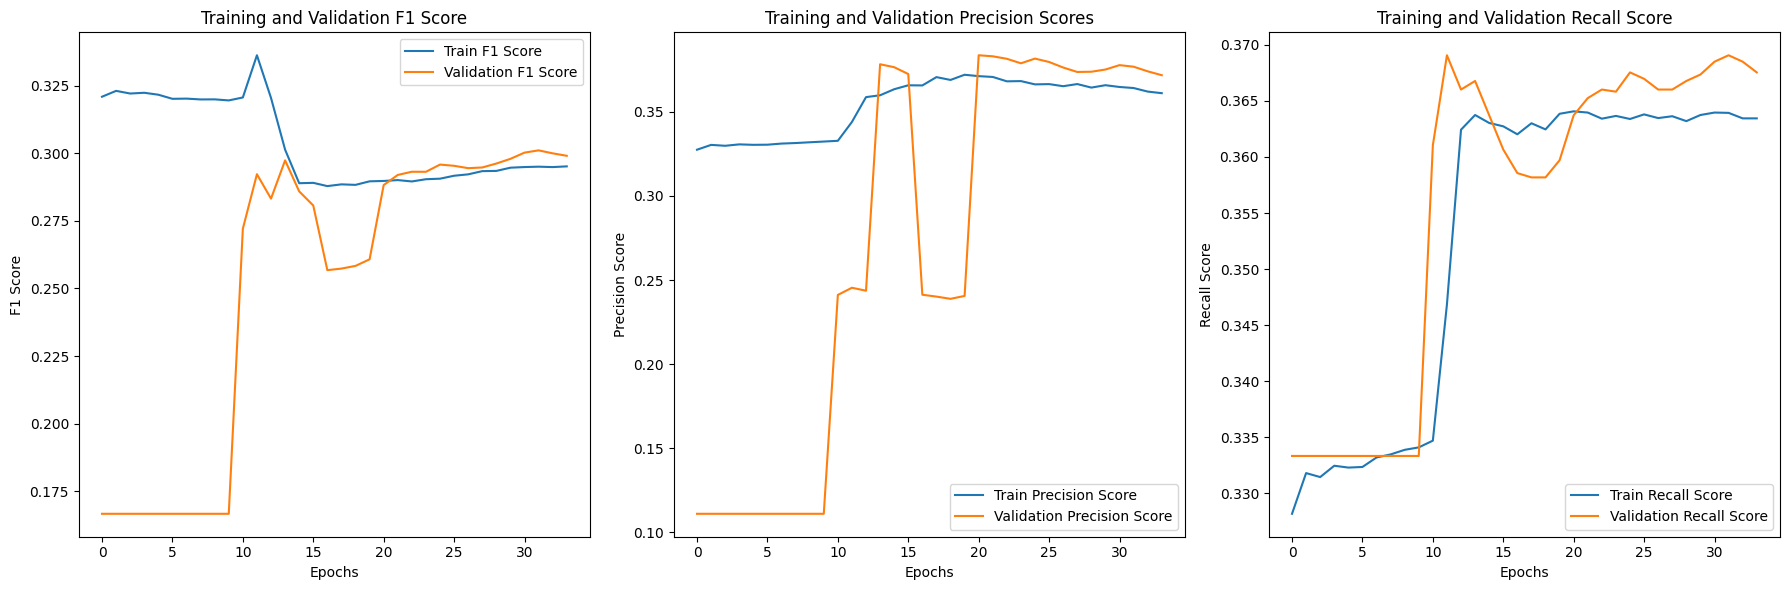

In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_13(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Softmax **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>ReLu</h2>

In [29]:
class Net_14(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_14, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** FOR ReLu **** 

Epoch 1/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.28, Train Precision: 0.35, Valid Precision: 0.40, Train Recall: 0.35, Valid Recall: 0.37
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.37, Valid Precision: 0.41, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.38, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall:

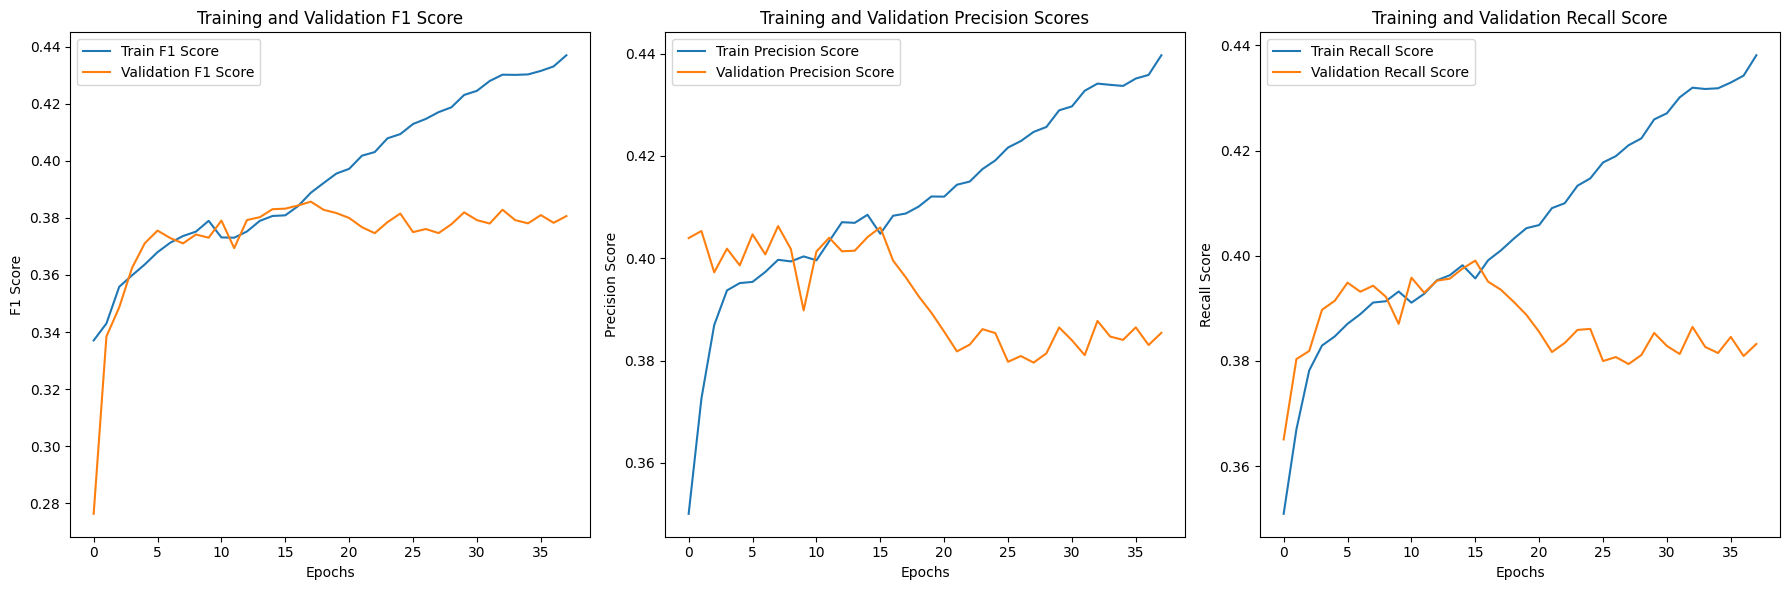

In [30]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_14(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR ReLu **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>ReLU and Softmax</h2>

In [31]:
class Net_15(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_15, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return self.softmax(x)



**** FOR ReLu and Softmax at the output layer **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.41, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.31, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.37, Valid Recall: 0.37
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.33, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.33, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 6/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.41, T

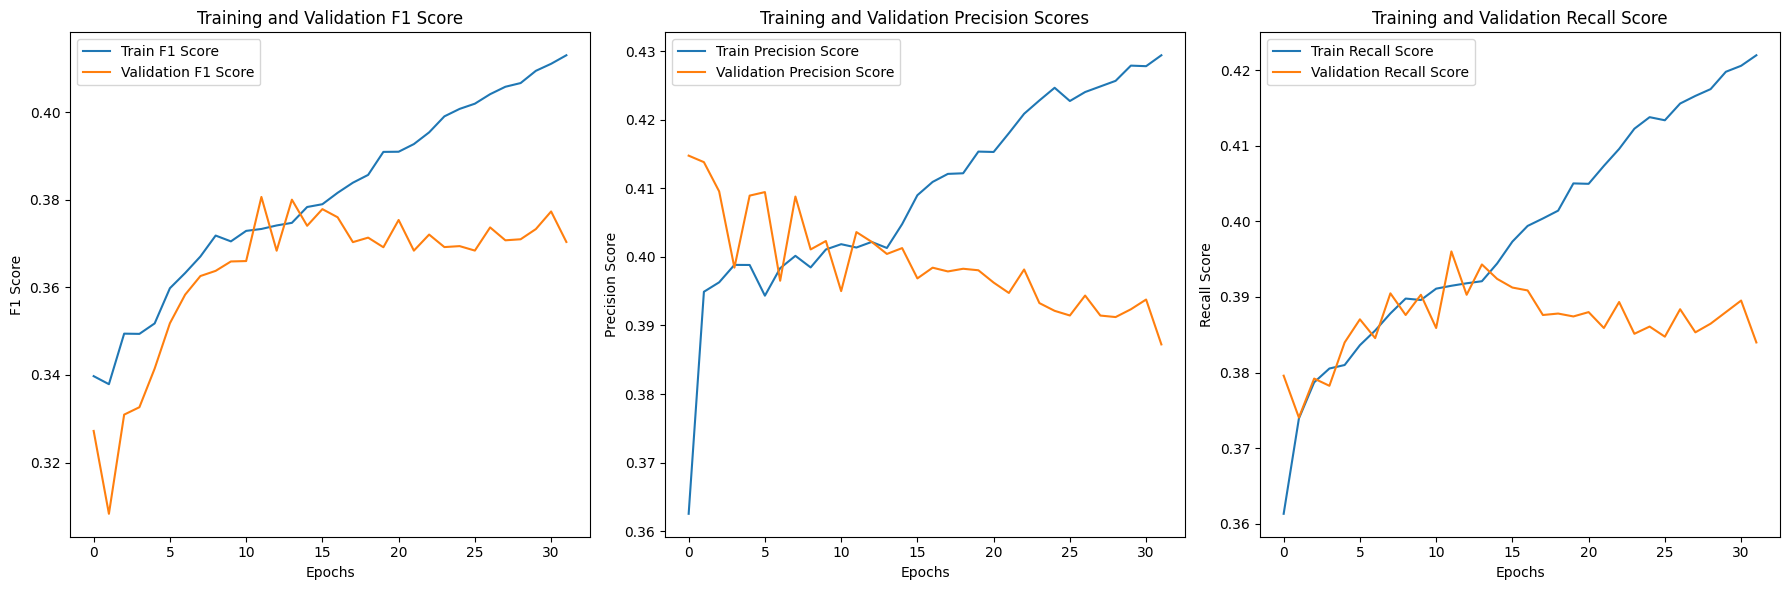

In [33]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_15(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR ReLu and Softmax at the output layer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h1>Experiments with optimizers</h1>

In [19]:
class Net_16(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_16, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x

<h2>SGD</h2>


**** FOR SGD optimizer **** 

Epoch 1/100, Train Acc: 0.33, Valid Acc: 0.34, Train F1: 0.26, Valid F1: 0.25, Train Precision: 0.34, Valid Precision: 0.35, Train Recall: 0.33, Valid Recall: 0.34
Epoch 2/100, Train Acc: 0.34, Valid Acc: 0.35, Train F1: 0.33, Valid F1: 0.31, Train Precision: 0.34, Valid Precision: 0.36, Train Recall: 0.34, Valid Recall: 0.35
Epoch 3/100, Train Acc: 0.35, Valid Acc: 0.36, Train F1: 0.35, Valid F1: 0.33, Train Precision: 0.35, Valid Precision: 0.37, Train Recall: 0.35, Valid Recall: 0.36
Epoch 4/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.35, Valid Precision: 0.38, Train Recall: 0.35, Valid Recall: 0.37
Epoch 5/100, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.35, Valid Precision: 0.38, Train Recall: 0.36, Valid Recall: 0.37
Epoch 6/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.36, Valid Precision: 0.38, Train Recall: 0.36, Vali

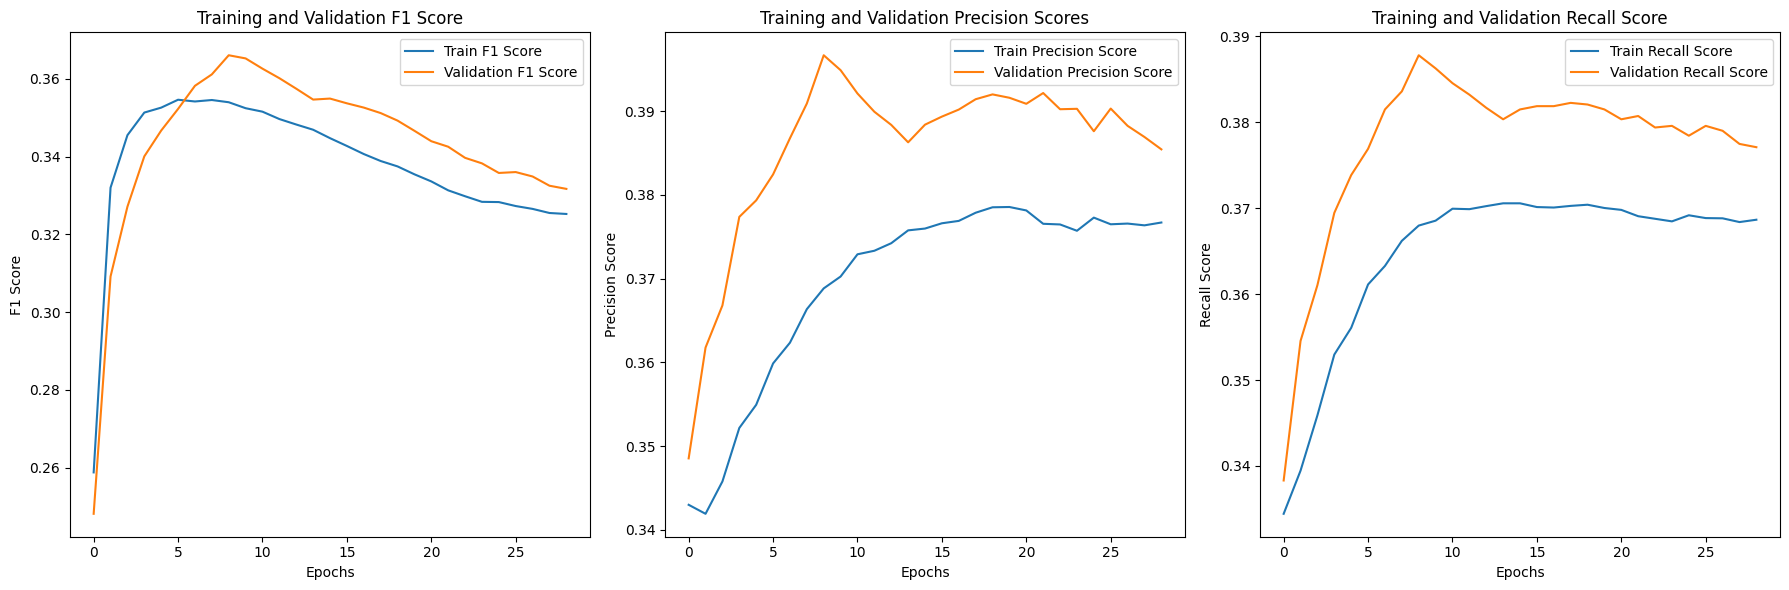

In [18]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_16(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR SGD optimizer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Adagrad</h2>


**** FOR Adagrad optimizer **** 

Epoch 1/100, Train Acc: 0.35, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.33, Train Precision: 0.36, Valid Precision: 0.36, Train Recall: 0.35, Valid Recall: 0.37
Epoch 2/100, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.36, Valid Precision: 0.36, Train Recall: 0.36, Valid Recall: 0.37
Epoch 3/100, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.37, Valid Precision: 0.37, Train Recall: 0.37, Valid Recall: 0.37
Epoch 4/100, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.37, Valid Precision: 0.37, Train Recall: 0.37, Valid Recall: 0.37
Epoch 5/100, Train Acc: 0.37, Valid Acc: 0.37, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.37, Valid Precision: 0.38, Train Recall: 0.37, Valid Recall: 0.37
Epoch 6/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.38, Valid Precision: 0.38, Train Recall: 0.37, 

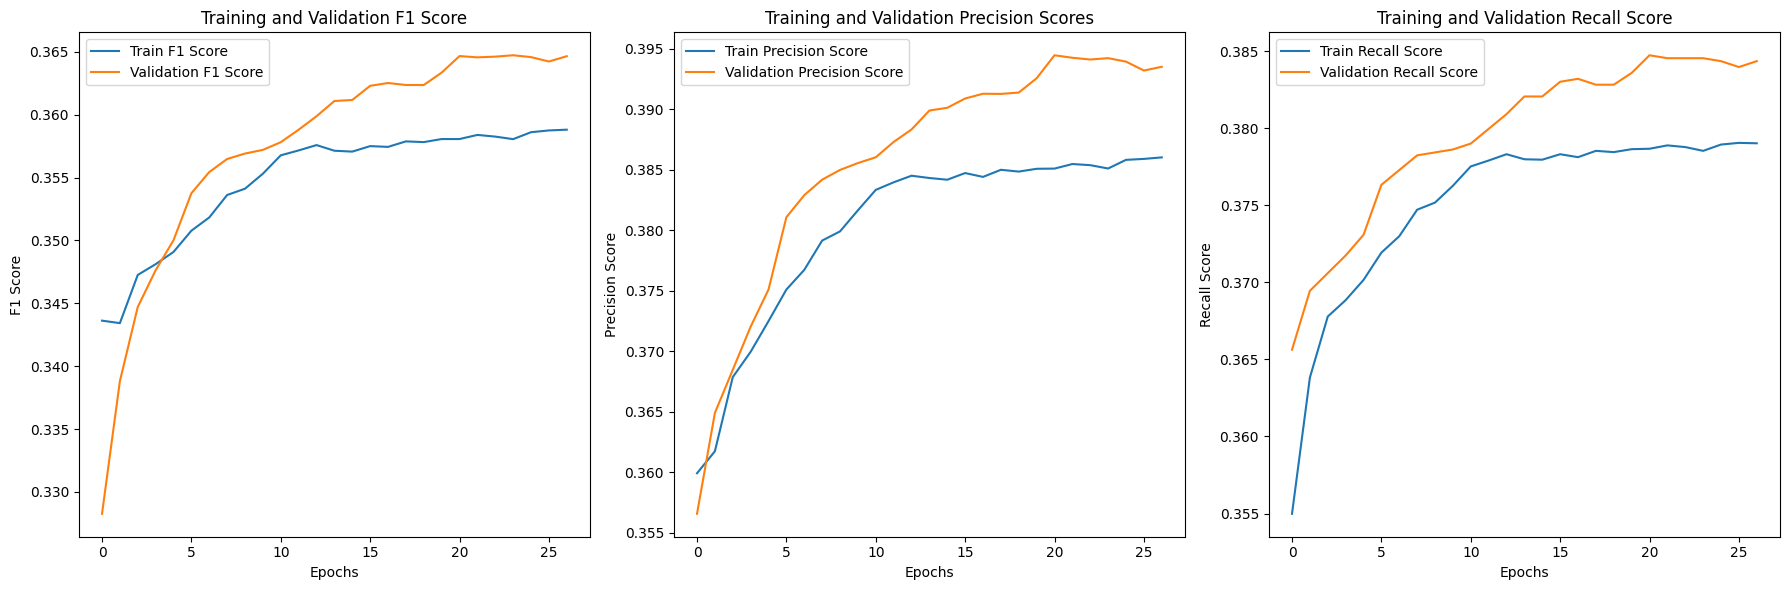

In [20]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_16(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Adagrad optimizer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>RMSprop</h2>


**** FOR RMSprop optimizer **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.34, Valid F1: 0.32, Train Precision: 0.36, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.37
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.39
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.39, 

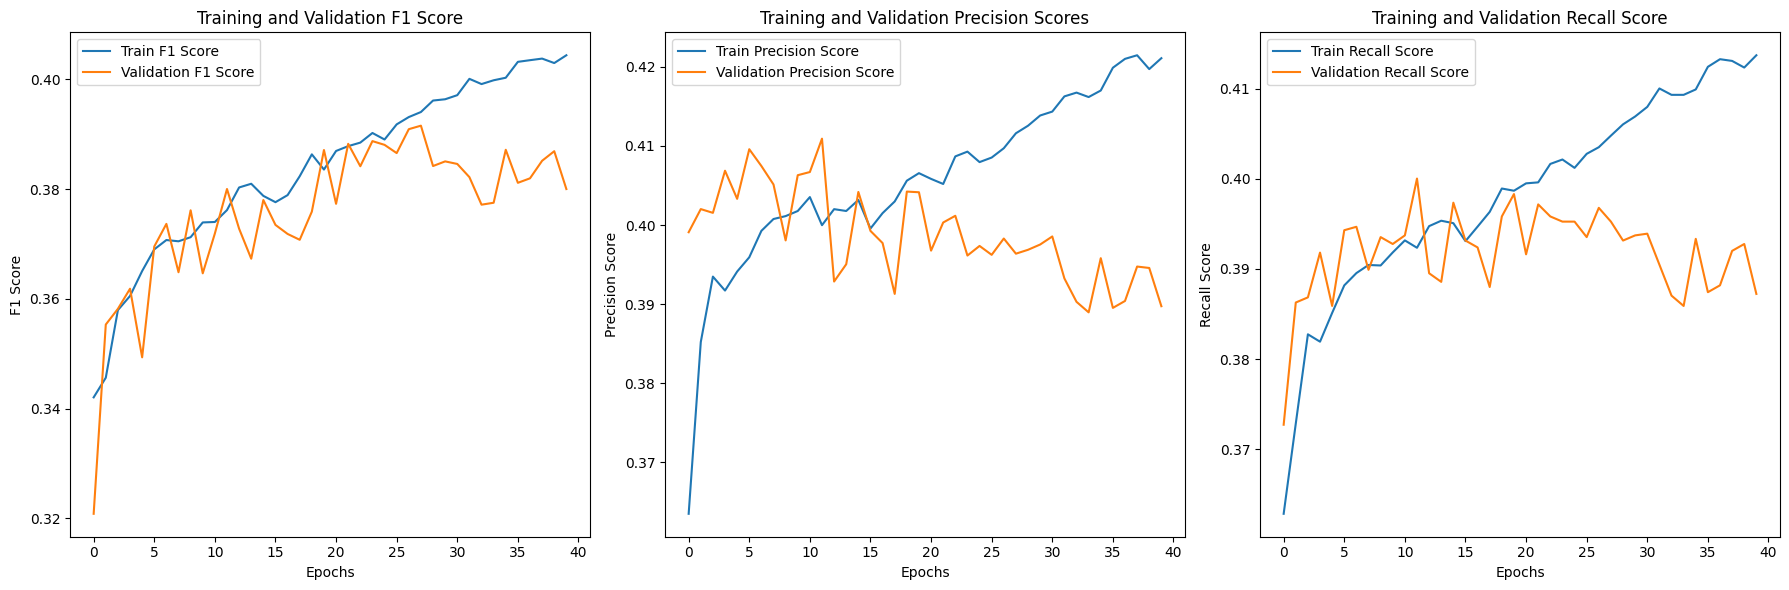

In [21]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_16(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR RMSprop optimizer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Adam</h2>


**** FOR Adam optimizer **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.35, Train Precision: 0.37, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.34, Train Precision: 0.39, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 5/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.37, Valid F1: 0.37, Train Precision: 0.39, Valid Precision: 0.40, Train Recall: 0.39, Val

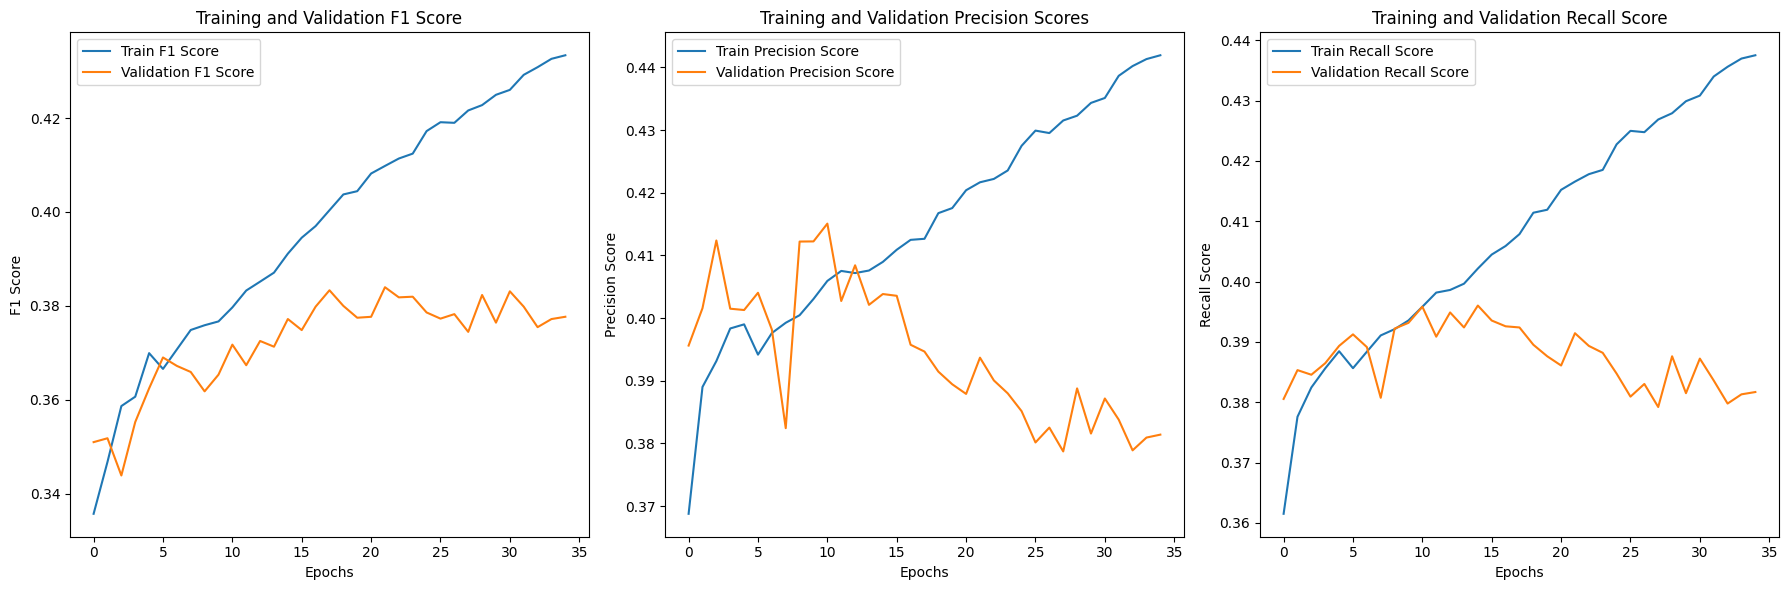

In [22]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_16(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR Adam optimizer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>AdamW</h2>


**** FOR AdamW optimizer **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.37, Train F1: 0.32, Valid F1: 0.32, Train Precision: 0.37, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.37
Epoch 2/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.34, Train Precision: 0.40, Valid Precision: 0.41, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.37, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.39, Va

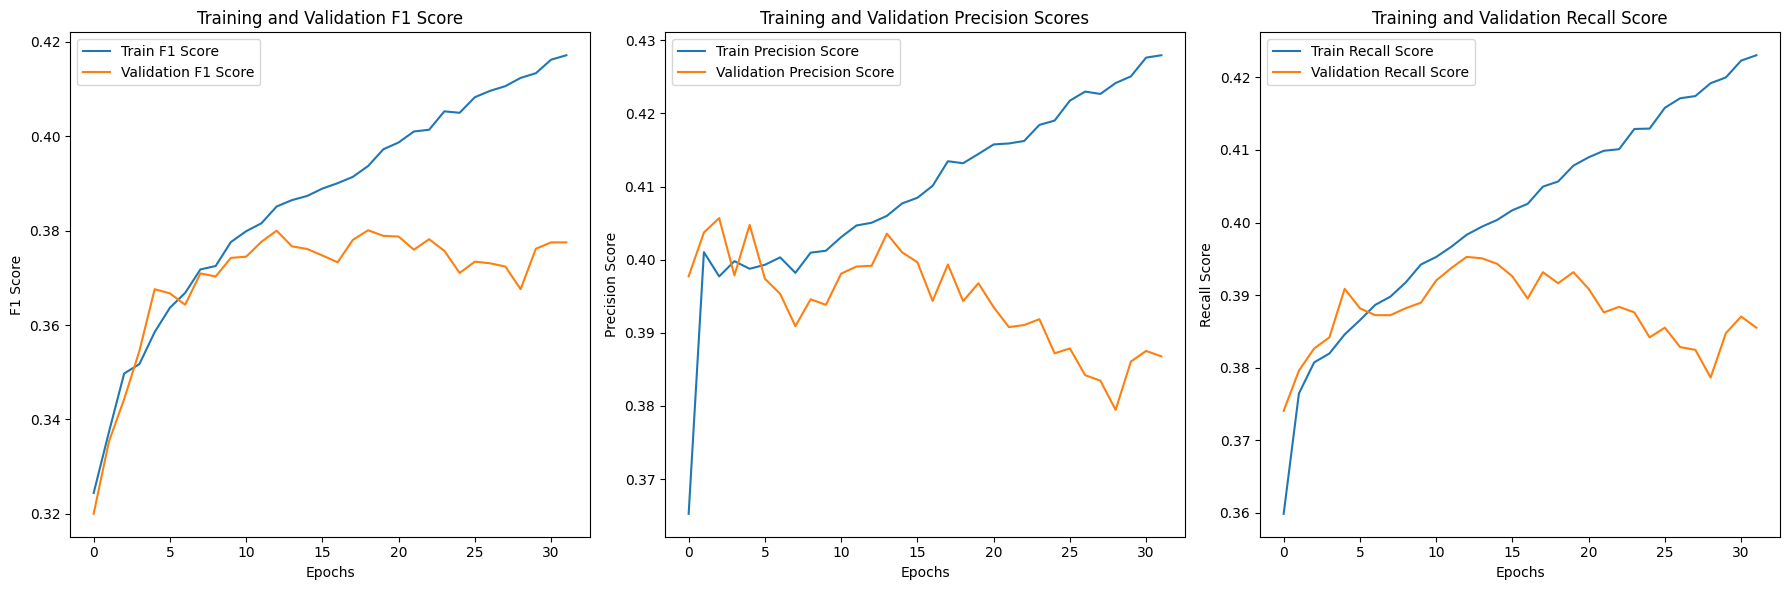

In [23]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_16(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** FOR AdamW optimizer **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h2>Concatenate the columns Party and Text</h2>

<p>We will concatenate the Party and the Text column and train again our model to observe if we achieve better results</p>

In [31]:
df_train_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
df_test_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')
df_valid_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')

In [32]:
df_train_set_concat = df_train_set
df_test_set_concat = df_test_set
df_valid_set_concat = df_valid_set
df_train_set_concat['Text'] = df_train_set_concat['Text'] + ' ' + df_train_set_concat['Party']
df_valid_set_concat['Text'] = df_valid_set_concat['Text'] + ' ' + df_valid_set_concat['Party']
df_test_set_concat['Text'] = df_test_set_concat['Text'] + ' ' + df_test_set_concat['Party']

In [33]:
le = LabelEncoder()
df_train_set_concat['Sentiment'] = le.fit_transform(df_train_set_concat['Sentiment'])
df_valid_set_concat['Sentiment'] = le.fit_transform(df_valid_set_concat['Sentiment'])

df_train_set_concat['Text'] = df_train_set_concat['Text'].apply(preprocess_tweet)
df_test_set_concat['Text'] = df_test_set_concat['Text'].apply(preprocess_tweet)
df_valid_set_concat['Text'] = df_valid_set_concat['Text'].apply(preprocess_tweet)

df_train_set_concat['Text'] = df_train_set_concat['Text'].apply(lemmatize_tokenize_text)
df_test_set_concat['Text'] = df_test_set_concat['Text'].apply(lemmatize_tokenize_text)
df_valid_set_concat['Text'] = df_valid_set_concat['Text'].apply(lemmatize_tokenize_text)

all_text = pd.concat([df_train_set_concat['Text'], df_test_set_concat['Text'], df_valid_set_concat['Text']])
tokenized_text = [text.split() for text in all_text]

# training
w2v_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

df_train_set_concat['Text'] = df_train_set_concat['Text'].apply(lambda x: vectorize(x, w2v_model))
df_test_set_concat['Text'] = df_test_set_concat['Text'].apply(lambda x: vectorize(x, w2v_model))
df_valid_set_concat['Text'] = df_valid_set_concat['Text'].apply(lambda x: vectorize(x, w2v_model))

# CONVERT DATA TO TENSORS
X_train = torch.tensor(df_train_set_concat['Text'].tolist(), dtype=torch.float)
y_train = torch.tensor(df_train_set_concat['Sentiment'].values, dtype=torch.float)
X_valid = torch.tensor(df_valid_set_concat['Text'].tolist(), dtype=torch.float)
y_valid = torch.tensor(df_valid_set_concat['Sentiment'].values, dtype=torch.float)

# CREATE DATALOADERS
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [34]:
class Net_17(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_17, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x


**** Results from concatenated columns Text and Party **** 

Epoch 1/100, Train Acc: 0.36, Valid Acc: 0.38, Train F1: 0.33, Valid F1: 0.32, Train Precision: 0.36, Valid Precision: 0.40, Train Recall: 0.36, Valid Recall: 0.38
Epoch 2/100, Train Acc: 0.37, Valid Acc: 0.38, Train F1: 0.34, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.37, Valid Recall: 0.38
Epoch 3/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.35, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 4/100, Train Acc: 0.38, Valid Acc: 0.38, Train F1: 0.36, Valid F1: 0.35, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.38
Epoch 5/100, Train Acc: 0.38, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision: 0.40, Train Recall: 0.38, Valid Recall: 0.39
Epoch 6/100, Train Acc: 0.39, Valid Acc: 0.39, Train F1: 0.36, Valid F1: 0.36, Train Precision: 0.40, Valid Precision:

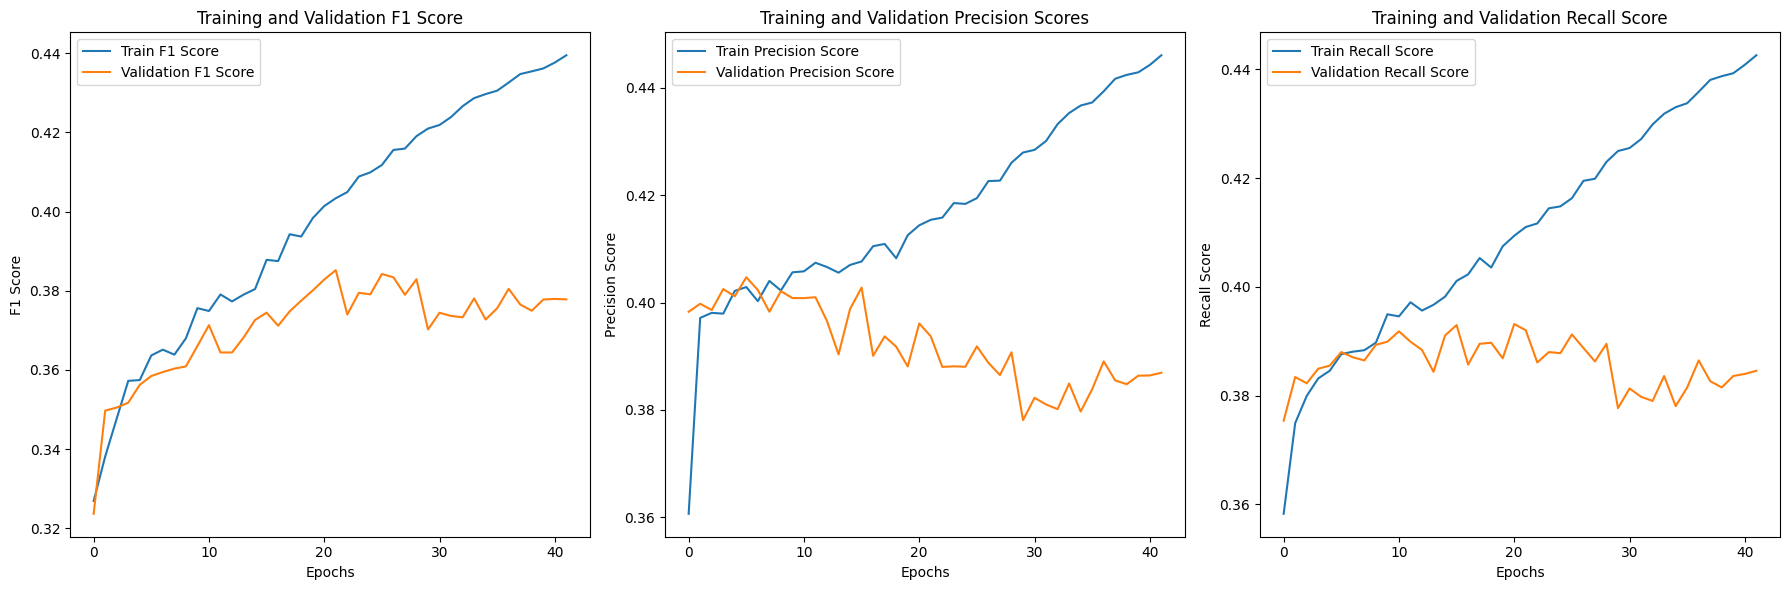

In [35]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

model = Net_17(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
print(f'\n**** Results from concatenated columns Text and Party **** \n')
train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision = train_with_batch_size(model, loss_func, optimizer, num_epochs, scheduler, train_loader, valid_loader)
plot_f1_recall_precision(train_f1, valid_f1, train_recall, valid_recall, train_precision, valid_precision)

<h1>Make predictions</h1>

In [43]:
def train_for_predictions(model, loss_func, optimizer, num_epochs, scheduler, train_loader):

    train_f1, valid_f1 = [], []
    best_train_f1 = 0
    epochs_no_improve = 0
    patience = 20
    
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels.long())
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        train_f1.append(f1_score(train_labels, train_preds, average='weighted', zero_division=0))

        scheduler.step()
            
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train F1: {train_f1[-1]:.2f}')

        temp_f1 = round(train_f1[-1], 2)
        if temp_f1 > best_train_f1:
            best_train_f1 = temp_f1
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    print(f'MEAN TRAIN F1 SCORE: {np.mean(train_f1):.2f}\n')
    return train_f1, model


In [41]:
class Net_18(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(Net_18, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.act_1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.act_2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        self.act_3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, H4)
        self.act_4 = nn.ReLU()
        self.linear5 = nn.Linear(H4, D_out)
        
    def forward(self, x):
        x = self.act_1(self.linear1(x))
        x = self.act_2(self.linear2(x))
        x = self.act_3(self.linear3(x))
        x = self.act_4(self.linear4(x))
        x = self.linear5(x)
        return x

In [33]:
df_train_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
df_test_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')
df_valid_set = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')
le = LabelEncoder()

df_train_set['Sentiment'] = le.fit_transform(df_train_set['Sentiment'])
df_valid_set['Sentiment'] = le.fit_transform(df_valid_set['Sentiment'])

df_train_set['Text'] = df_train_set['Text'].apply(preprocess_tweet)
df_test_set['Text'] = df_test_set['Text'].apply(preprocess_tweet)
df_valid_set['Text'] = df_valid_set['Text'].apply(preprocess_tweet)

df_train_set['Text'] = df_train_set['Text'].apply(lemmatize_tokenize_text)
df_test_set['Text'] = df_test_set['Text'].apply(lemmatize_tokenize_text)
df_valid_set['Text'] = df_valid_set['Text'].apply(lemmatize_tokenize_text)

df_extended = pd.concat([df_train_set, df_valid_set], ignore_index=True)

all_text = pd.concat([df_extended['Text'], df_test_set['Text']])
tokenized_text = [text.split() for text in all_text]

# training
w2v_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

df_train_set_extended_vectorized = df_extended
df_test_set_vectorized = df_test_set

df_train_set_extended_vectorized['Text'] = df_train_set_extended_vectorized['Text'].apply(lambda x: vectorize(x, w2v_model))
df_test_set_vectorized['Text'] = df_test_set_vectorized['Text'].apply(lambda x: vectorize(x, w2v_model))

# CONVERT DATA TO TENSORS
X_train = torch.tensor(df_train_set_extended_vectorized['Text'].tolist(), dtype=torch.float)
y_train = torch.tensor(df_train_set_extended_vectorized['Sentiment'].values, dtype=torch.float)

# CREATE DATALOADERS
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)


In [ ]:
model = Net_18(D_in=100, H1=264, H2=128, H3=64, H4=32, D_out=3)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train_f1, model= train_for_predictions(model, loss_func, optimizer, num_epochs, scheduler, train_loader)


Epoch 1/100, Train F1: 0.33
Epoch 2/100, Train F1: 0.34
Epoch 3/100, Train F1: 0.35
Epoch 4/100, Train F1: 0.35
Epoch 5/100, Train F1: 0.35
Epoch 6/100, Train F1: 0.36
Epoch 7/100, Train F1: 0.36
Epoch 8/100, Train F1: 0.37
Epoch 9/100, Train F1: 0.37
Epoch 10/100, Train F1: 0.37
Epoch 11/100, Train F1: 0.37
Epoch 12/100, Train F1: 0.37
Epoch 13/100, Train F1: 0.37
Epoch 14/100, Train F1: 0.38
Epoch 15/100, Train F1: 0.38
Epoch 16/100, Train F1: 0.38
Epoch 17/100, Train F1: 0.38
Epoch 18/100, Train F1: 0.38
Epoch 19/100, Train F1: 0.39
Epoch 20/100, Train F1: 0.39
Epoch 21/100, Train F1: 0.39
Epoch 22/100, Train F1: 0.40
Epoch 23/100, Train F1: 0.40
Epoch 24/100, Train F1: 0.40
Epoch 25/100, Train F1: 0.40
Epoch 26/100, Train F1: 0.41
Epoch 27/100, Train F1: 0.41
Epoch 28/100, Train F1: 0.41
Epoch 29/100, Train F1: 0.41
Epoch 30/100, Train F1: 0.41
Epoch 31/100, Train F1: 0.42
Epoch 32/100, Train F1: 0.42
Epoch 33/100, Train F1: 0.42
Epoch 34/100, Train F1: 0.42
Epoch 35/100, Train F1:

In [45]:
X_test = torch.tensor(df_test_set_vectorized['Text'].tolist(), dtype=torch.float)

test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model.eval()

with torch.no_grad():
    test_preds = []
    for inputs in test_loader:
        inputs = inputs[0]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())

predicted_labels = le.inverse_transform(test_preds)

In [49]:
results = pd.DataFrame({
    'Id': df_test_set['New_ID'],
    'Predicted': predicted_labels
})

results.to_csv('submission.csv', index=False)
results

Id Predicted
0          1  POSITIVE
1          2  POSITIVE
2          3  POSITIVE
3          4  POSITIVE
4          5  POSITIVE
...      ...       ...
10465  10466  NEGATIVE
10466  10467  NEGATIVE
10467  10468  POSITIVE
10468  10469   NEUTRAL
10469  10470  NEGATIVE

[10470 rows x 2 columns]